# **TESTING CUSTOM RANDOM FOREST IMPLEMENTATION**

# Model

In [17]:
import numpy as np
from sklearn.utils._param_validation import StrOptions

from sklearn.ensemble._forest import ForestClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from sklearn.base import clone
from sklearn.ensemble._base import _set_random_states

def _unwrap_data(X, y, sample_weight):
    if sample_weight is None:
        return X, y

    return np.repeat(X, sample_weight.astype(int), axis=0), np.repeat(y, sample_weight.astype(int), axis=0)

class OSRandomForestClassifier(ForestClassifier):

    _parameter_constraints: dict = {
        **ForestClassifier._parameter_constraints,
        **DecisionTreeClassifier._parameter_constraints,
        "class_weight": [
            StrOptions({"balanced_subsample", "balanced"}),
            dict,
            list,
            None,
        ],
    }
    _parameter_constraints.pop("splitter")

    def __init__(
        self,
        oversampling_strategy="random",
        print_indices_list=None,
        n_estimators=100,
        *,
        criterion="gini",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features="sqrt",
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        ccp_alpha=0.0,
        max_samples=None,
        monotonic_cst=None,
    ):
        super().__init__(
            estimator=OSDecisionTreeClassifier(
                oversampling_strategy=oversampling_strategy,
                print_var=False,
            ),
            n_estimators=n_estimators,
            estimator_params=(
                "criterion",
                "max_depth",
                "min_samples_split",
                "min_samples_leaf",
                "min_weight_fraction_leaf",
                "max_features",
                "max_leaf_nodes",
                "min_impurity_decrease",
                "random_state",
                "ccp_alpha",
                "monotonic_cst",
            ),
            bootstrap=bootstrap,
            oob_score=oob_score,
            n_jobs=n_jobs,
            random_state=random_state,
            verbose=verbose,
            warm_start=warm_start,
            class_weight=class_weight,
            max_samples=max_samples,
        )

        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.max_features = max_features
        self.max_leaf_nodes = max_leaf_nodes
        self.min_impurity_decrease = min_impurity_decrease
        self.monotonic_cst = monotonic_cst
        self.ccp_alpha = ccp_alpha
        self.oversampling_strategy = oversampling_strategy
        self.current_tree_count = 0
        self.print_indices_list = print_indices_list if print_indices_list is not None else []

    def _make_estimator(self, append=True, random_state=None):
        self.current_tree_count += 1
        tree_index = self.current_tree_count
        print_var = tree_index in self.print_indices_list
        estimator = clone(self.estimator_)
        estimator.set_params(**{p: getattr(self, p) for p in self.estimator_params},
                             print_var=print_var
                             )

        if random_state is not None:
            _set_random_states(estimator, random_state)

        if append:
            self.estimators_.append(estimator)

        return estimator


class OSDecisionTreeClassifier(DecisionTreeClassifier):
    def __init__(
        self,
        *,
        print_var=False,
        oversampling_strategy="random",
        criterion="gini",
        splitter="best",
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_weight_fraction_leaf=0.0,
        max_features=None,
        random_state=None,
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        class_weight=None,
        ccp_alpha=0.0,
        monotonic_cst=None,
    ):
        # print(f"Oversampling strategy: {oversampling_strategy}")
        super().__init__(
            criterion=criterion,
            splitter=splitter,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            min_weight_fraction_leaf=min_weight_fraction_leaf,
            max_features=max_features,
            random_state=random_state,
            max_leaf_nodes=max_leaf_nodes,
            min_impurity_decrease=min_impurity_decrease,
            class_weight=class_weight,
            ccp_alpha=ccp_alpha,
            monotonic_cst=monotonic_cst,
        )
        self.oversampling_strategy = oversampling_strategy
        self.print_var = print_var

    def _fit(
        self,
        X,
        y,
        sample_weight=None,
        check_input=True,
        missing_values_in_feature_mask=None,
    ):
        if self.oversampling_strategy == "random":
            sampler = RandomOverSampler(random_state=self.random_state)
        elif self.oversampling_strategy == "SMOTE":
            sampler = SMOTE(random_state=self.random_state)
            # print(f"Using SMOTE with random_state={self.random_state} to generate synthetic samples.")
        elif  self.oversampling_strategy == "BorderlineSMOTE":
            sampler = BorderlineSMOTE(random_state=self.random_state)
            # print(f"Using BorderlineSMOTE with random_state={self.random_state} to generate synthetic samples.")
        elif self.oversampling_strategy == "ADASYN":
            sampler = ADASYN(random_state=self.random_state)
        else:
            raise ValueError(
                f"Oversampling strategy {self.oversampling_strategy} is not supported."
            )

        X_drawn, y_drawn = _unwrap_data(X, y, sample_weight)
        X_resampled, y_resampled = sampler.fit_resample(X_drawn, y_drawn)
        count_1 = sum(y_resampled == 1)
        count_0 = sum(y_resampled == 0)
        # print(f"Count of 1s: {count_1}, Count of 0s: {count_0}")

        sample_weight = [1] * len(X_drawn) + [0.5] * (len(X_resampled) - len(X_drawn))
        # sample_weight = None

        # print(f"len X_drawn: {len(X_drawn)}")
        # print(f"len X_resampled: {len(X_resampled)}")
        # print(X_drawn[:6, 0])
        # print(X_resampled[:6, 0])

        # if self.print_var:
        #     print("Pekaboo!")
        # else:
        #     print("Nope, not this time!")

        return super()._fit(
            # X, y,
            X_resampled,
            y_resampled,
            sample_weight=sample_weight,
            check_input=check_input,
            missing_values_in_feature_mask=missing_values_in_feature_mask,
        )

# Test

In [18]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imblearn.datasets import fetch_datasets
us_crime = fetch_datasets()['us_crime']

X = us_crime.data
y = us_crime.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

rf = OSRandomForestClassifier(oversampling_strategy='SMOTE', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("=== RF with SMOTE ===")
print(classification_report(y_test, y_pred))

=== RF with SMOTE ===
              precision    recall  f1-score   support

          -1       0.96      0.97      0.96       554
           1       0.57      0.51      0.54        45

    accuracy                           0.93       599
   macro avg       0.77      0.74      0.75       599
weighted avg       0.93      0.93      0.93       599



# **TESTING MODEL COMPARATOR**

# Comparator

In [31]:
from imblearn.datasets import fetch_datasets
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, recall_score
from scipy.stats import gmean
from sklearn.model_selection import train_test_split
from os_sklearn.ensemble._forest import OSRandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from umap import UMAP
import warnings
warnings.filterwarnings('ignore')


class Comparator:
    def __init__(
            self,
            datasets=[[fetch_datasets()['us_crime'].data, fetch_datasets()['us_crime'].target],
                      [fetch_datasets()['letter_img'].data, fetch_datasets()['letter_img'].target]],
            test_size=0.2,
            oversampling_strategies=['random', 'SMOTE', 'BorderlineSMOTE', 'ADASYN'], # 'random', 'SMOTE', 'BorderlineSMOTE', 'ADASYN'
            metrics=['precision', 'recall', 'f1-score', 'accuracy', 'auc', 'g-mean'], # 'precision', 'recall', 'f1-score', 'accuracy', 'auc', 'g-mean'
            n_trees=100,
            iterations=100,
            dataset_names=['us_crime', 'letter_img'],
            mode='both', # 'both', 'bagging', 'augmentation'
            seprate_plots_for_classes=False,
            plot_type = 'box', # 'box', 'violin'
            plot_datasets=False
    ):
        self.datasets = datasets
        self.test_size = test_size
        self.oversampling_strategies = oversampling_strategies
        self.metrics = metrics
        self.n_trees = n_trees
        self.iterations = iterations
        self.dataset_names = dataset_names
        self.mode = mode
        self.prepare_data()
        self.results = pd.DataFrame(columns=['forest_index', 
                                             'dataset', 
                                             'type', 
                                             'strategy', 
                                             'iteration', 
                                             'class', 
                                             'metric', 
                                             'value'])
        self.augmentation_storage = []
        self.forests_storage = []
        self.forest_counter = 0
        self.plot_classes = seprate_plots_for_classes
        self.plot_type = plot_type
        self.plot_datasets = plot_datasets


    def prepare_data(self):
        self.labels = []
        for i in range(len(self.datasets)):
            dataset = self.datasets[i]
            X, y = dataset[0], dataset[1]
            labels = np.unique(y)
            self.datasets[i] = train_test_split(X, y, test_size=self.test_size, stratify=y)
            self.labels.append(labels)


    def get_forest_id(self, type, dataset_name, strategy, iteration):
        df = self.results
        row = df[(df['dataset'] == dataset_name) & 
                 (df['type'] == type) &
                 (df['strategy'] == strategy) & 
                 (df['iteration'] == iteration)]
        if not row.empty:
            return row.iloc[0]['forest_index']
        else:
            return None
        

    def compute(self):
        print('=========================================================================')
        print('=========================     START COMPUTING     =======================')
        print('=========================================================================\n')

        print(f'Datasets: {self.dataset_names}')
        print(f'Mode: {self.mode}')
        print(f'Oversampling strategies: {self.oversampling_strategies}')
        print(f'Metrics: {self.metrics}')
        print(f'Iterations: {self.iterations}')
        print(f'Number of trees: {self.n_trees}')

        for i in range(len(self.datasets)):
            dataset_name = self.dataset_names[i]
            labels = self.labels[i]
            data = self.datasets[i]
            print(f'\n \n + DATASET: {dataset_name}')
            if self.mode in ['both', 'bagging']:
                self.compute_bagging(data, dataset_name, labels)
            if self.mode in ['both', 'augmentation']:
                self.compute_augmentation(data, dataset_name, labels)
            else:
                raise ValueError(f"Mode {self.mode} is not supported. Choose from 'both', 'bagging', or 'augmentation'.")
            self.compute_baseline(data, dataset_name, labels)
            
        print('\n=========================================================================')
        print('==================     COMPUTING ENDED SUCCESSFULLY      ================')
        print('=========================================================================\n')


    def _print_progress_bar(self, iteration, prefix='', length=30):
        percent = f"{100 * (iteration / float(self.iterations)):.1f}"
        filled_length = int(length * iteration // self.iterations)
        bar = '█' * filled_length + '-' * (length - filled_length)
        print(f'\r{prefix} |{bar}| {percent}% Complete', end='\r', flush=True)
        if iteration == self.iterations:
            print()


    def extract_metrics(self, type, report, dataset_name, strategy, iteration, labels, forest, X_test, y_test, y_pred):

        for cls in labels:
            for metric in self.metrics:
                if metric in ['accuracy', 'auc', 'g-mean']:
                    continue
                if metric in report[str(cls)]:
                    self.results.loc[len(self.results)] = [
                        self.forest_counter,
                        dataset_name,
                        type, 
                        strategy,
                        iteration, 
                        str(cls), 
                        metric, 
                        report[str(cls)][metric]]
                else:
                    raise ValueError(f"Metric {metric} not found in report for class {cls}.")
                        
        if 'accuracy' in self.metrics:
            self.results.loc[len(self.results)] = [
                self.forest_counter, dataset_name, type, strategy, iteration, 'all', 'accuracy', report['accuracy']]
            
        if 'precision' in self.metrics:
            self.results.loc[len(self.results)] = [
                self.forest_counter, dataset_name, type, strategy, iteration, 'all', 'precision', report['macro avg']['precision']]
            
        if 'recall' in self.metrics:
            self.results.loc[len(self.results)] = [
                self.forest_counter, dataset_name, type, strategy, iteration, 'all', 'recall', report['macro avg']['recall']]
            
        if 'f1-score' in self.metrics:
            self.results.loc[len(self.results)] = [
                self.forest_counter, dataset_name, type, strategy, iteration, 'all', 'f1-score', report['macro avg']['f1-score']]
        
        if 'auc' in self.metrics:
            y_proba = forest.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)
            self.results.loc[len(self.results)] = [
                self.forest_counter, dataset_name, type, strategy, iteration, 'all', 'auc', auc]
                    
        if 'g-mean' in self.metrics:
            reacalls = recall_score(y_test, y_pred, average=None)
            gmean_val = gmean(reacalls)
            self.results.loc[len(self.results)] = [
                self.forest_counter, dataset_name, type, strategy, iteration, 'all', 'g-mean', gmean_val]
            


    def compute_bagging(self, data, dataset_name, labels):

        print('\n-=-=-=-=-=-=   BAGGING   =-=-=-=-=-')

        for strategy in self.oversampling_strategies:
            for j in range(self.iterations):

                self._print_progress_bar(j + 1, prefix=f'{strategy} - bagging')
                
                X_train, X_test, y_train, y_test = data

                forest = OSRandomForestClassifier(
                    oversampling_strategy=strategy,
                    n_estimators=self.n_trees)
                
                forest.fit(X_train, y_train)
                self.forests_storage.append(forest)
                y_pred = forest.predict(X_test)
                report = classification_report(y_test, y_pred, output_dict=True, target_names=[str(c) for c in labels])
                self.extract_metrics('bagging', report, dataset_name, strategy, j, labels, forest, X_test, y_test, y_pred)
                    
                self.forest_counter += 1
                    

    def compute_augmentation(self, data, dataset_name, labels):

        print('\n-=-=-=-=-=-=   AUGMENTATION   =-=-=-=-=-')
        
        for strategy in self.oversampling_strategies:
            for j in range(self.iterations):

                self._print_progress_bar(j + 1, prefix=f'{strategy} - augmentation')

                X_train, X_test, y_train, y_test = data

                if strategy == "random":
                    sampler = RandomOverSampler()
                elif strategy == "SMOTE":
                    sampler = SMOTE()
                elif strategy == "BorderlineSMOTE":
                    sampler = BorderlineSMOTE()
                elif strategy == "ADASYN":
                    sampler = ADASYN()
                else:
                    raise ValueError(f"Oversampling strategy {strategy} is not supported.")
                
                forest = RandomForestClassifier(
                    n_estimators=self.n_trees
                )

                X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
                forest.fit(X_resampled, y_resampled)
                self.forests_storage.append(forest)
                y_pred = forest.predict(X_test)
                report = classification_report(y_test, y_pred, output_dict=True, target_names=[str(c) for c in labels])
                self.extract_metrics('augmentation', report, dataset_name, strategy, j, labels, forest, X_test, y_test, y_pred)

                self.augmentation_storage.append([
                    self.forest_counter, X_train, X_resampled, y_resampled])
                self.forest_counter += 1
    

    def compute_baseline(self, data, dataset_name, labels):

        print('\n-=-=-=-=-=-=   BASELINE   =-=-=-=-=-')

        for j in range(self.iterations):

            self._print_progress_bar(j + 1, prefix='baseline')

            X_train, X_test, y_train, y_test = data
            forest = RandomForestClassifier(
                n_estimators=self.n_trees
            )
            forest.fit(X_train, y_train)
            self.forests_storage.append(forest)
            y_pred = forest.predict(X_test)
            report = classification_report(y_test, y_pred, output_dict=True, target_names=[str(c) for c in labels])

            self.extract_metrics('baseline', report, dataset_name, '-', j, labels, forest, X_test, y_test, y_pred)
            self.forest_counter += 1
    

    def print_table(self, type, dataset, strategy, labels):
        df = self.results
        for metric in self.metrics:
            if metric in ['accuracy', 'auc', 'g-mean']:
                continue
            else:
                print(f"\n{'':>12} {'min_'+metric:>12} {'avg_'+metric:>12} {'max_'+metric:>12} {'std_'+metric:>12}")
                for cls in labels:
                    vals = df[
                        (df['class'] == str(cls)) & 
                        (df['type'] == type) &
                        (df['metric'] == metric) & 
                        (df['strategy'] == strategy) & 
                        (df['dataset'] == dataset)]['value'].astype(float)
                    if not vals.empty:
                        print(f"{str(cls):>12} {vals.min():12.4f} {vals.mean():12.4f} {vals.max():12.4f} {vals.std():12.4f}")
                    else:
                        print(f"{str(cls):>12} {'N/A':>12} {'N/A':>12} {'N/A':>12} {'N/A':>12}")
        
        for metric in self.metrics:
            vals = df[
                (df['metric'] == metric) &
                (df['class'] == 'all') &
                (df['type'] == type) & 
                (df['strategy'] == strategy) & 
                (df['dataset'] == dataset)]['value'].astype(float)
            print(f"\n{'':>12} {'min':>12} {'avg':>12} {'max':>12} {'std':>12}")
            print(f"{metric+' :':>12} {vals.min():12.4f} {vals.mean():12.4f} {vals.max():12.4f} {vals.std():12.4f}")


    def plot_metrics(self, dataset, labels):

        if self.plot_type == 'box':
            plot = sns.boxplot
        elif self.plot_type == 'violin':
            plot = sns.violinplot
        else:
            raise ValueError("plot_type must be either 'box' or 'violin'.")
        
        df = self.results

        palettes = [
            ["#b39ddb"], 
            ["#a5d6a7"],
            ["#90caf9"],
            ["#fff59d"],
            ["#ef9a9a"],
            ["#ffcc80"]
        ]
        
        palette_idx = 0

        for metric in self.metrics:

            plt.figure(figsize=(8,6))
            plot(
                data=df[(df['metric'] == metric) & 
                        (df['dataset'] == dataset) &
                        (df['class'] == 'all')],
                x=df['type'] + '  ' + df['strategy'],
                y='value',
                palette=palettes[palette_idx]
            )
            plt.title(f'{metric.capitalize()} for {dataset}')
            plt.xlabel(None)
            plt.ylabel(None)
            plt.xticks(rotation=70)
            plt.tight_layout()
            plt.show()

            if metric in ['precision', 'recall', 'f1-score'] and self.plot_classes:
                for cls in labels:
                    plt.figure(figsize=(8,6))
                    plot(
                        data=df[(df['metric'] == metric) & 
                                (df['dataset'] == dataset) &
                                (df['class'] == str(cls))],
                        x=df['type'] + '  ' + df['strategy'],
                        y='value',
                        palette=palettes[palette_idx]
                    )
                    plt.title(f'{metric.capitalize()} for {dataset} - Class {cls}')
                    plt.xlabel(None)
                    plt.ylabel(None)
                    plt.xticks(rotation=70)
                    plt.tight_layout()
                    plt.show()

            palette_idx += 1

                
    def plot_data(self, forest_idx, tree_idx=None):

        if forest_idx >= self.forest_counter:
            raise ValueError(f"Forest index {forest_idx} is out of bounds. Maximum index is {self.forest_counter - 1}.")

        rows = self.results[self.results['forest_index'] == forest_idx]
        dataset = rows['dataset'].values[0]
        dataset_idx = self.dataset_names.index(dataset)
        labels = self.labels[dataset_idx]
        iteration = rows['iteration'].values[0]
        strategy = rows['strategy'].values[0]
        type = rows['type'].values[0]

        if type == 'bagging':
            if tree_idx is None:
                raise ValueError("For bagging tree_idx must be provided.")
            
            forest = self.forests_storage[forest_idx]
            visualization_data = forest.estimators_[tree_idx].visualization_pack
            X_drawn, X_resampled, y_resampled = visualization_data[0], visualization_data[1], visualization_data[2]
            title = f"(TSNE) {dataset} after {strategy} bagging (iteration: {iteration}, tree: {tree_idx})"

        elif type == 'augmentation':

            visualization_data = next((item for item in self.augmentation_storage if item[0] == forest_idx), None)
            _, X_drawn, X_resampled, y_resampled = visualization_data
            title = f"(TSNE) {dataset} after {strategy} augmentation (iteration: {iteration})"
        
        else:
            X_drawn, X_resampled, y_resampled = self.datasets[dataset_idx][0], self.datasets[dataset_idx][0], self.datasets[dataset_idx][2]
            title = f"(TSNE) {dataset}"

        # Prepare data for plotting
        if X_resampled.shape[1] == 1:
            X_plot = np.hstack([X_resampled, np.zeros((X_resampled.shape[0], 1))])
        elif X_resampled.shape[1] == 2:
            X_plot = X_resampled
        else:
            umap_model = UMAP(n_components=2)
            X_plot = umap_model.fit_transform(X_resampled)

        marker = len(X_drawn)

        orig_palette = sns.color_palette("magma", len(labels))
        synth_palette = sns.color_palette("viridis", len(labels))

        plt.figure(figsize=(8, 6))

        classes = np.unique(y_resampled)

        # Plot synthetic samples
        for idx, cls in enumerate(classes):
            synth_mask = (y_resampled[marker:] == cls)
            if np.any(synth_mask):
                sns.scatterplot(
                    x=X_plot[marker:, 0][synth_mask],
                    y=X_plot[marker:, 1][synth_mask],
                    color=synth_palette[idx],
                    marker="X",
                    s=100,
                    label=f"synthetic class:  {int(cls)}",
                    linewidth=0.4
                )

        # Plot original samples
        for idx, cls in enumerate(classes):
            orig_mask = np.array(y_resampled[:marker] == cls)
            sns.scatterplot(
                x=X_plot[:marker, 0][orig_mask],
                y=X_plot[:marker, 1][orig_mask],
                color=orig_palette[idx],
                marker="o",
                linewidth=0.4,
                s=40,
                label=f"class:  {int(cls)}"
            )

        plt.title(title)
        plt.legend()
        plt.tight_layout()
        plt.show()

        print('')
        for idx, cls in enumerate(classes):
            orig_mask = (y_resampled[:marker] == cls)
            if type == 'bagging':
                print(f"Class {int(cls)} has {np.sum(orig_mask)} original samples and {np.sum(y_resampled[marker:] == cls)} synthetic samples after {strategy} bagging.")
            elif type == 'augmentation':
                print(f"Class {int(cls)} has {np.sum(orig_mask)} original points and {np.sum(y_resampled[marker:] == cls)} synthetic points after {strategy} augmentation.")
            else:
                print(f"Class {int(cls)} has {np.sum(orig_mask)} points.")
        print('')


    def plot_dataset(self, dataset_name):
        df = self.results
        forest_idx = df[(df['dataset'] == dataset_name) & 
                        (df['type'] == 'baseline') & (df['strategy'] == '-')]['forest_index'].values[0]
        self.plot_data(forest_idx)


    def summary(self):
        print('\n', '=' * 73)
        print('=========================         SUMMARY         =======================')
        print('=' * 73, '\n')

        for i in range(len(self.datasets)):
            print('*' * 5, f' DATASET: {self.dataset_names[i]}\n')
            labels = self.labels[i]
            dataset_name = self.dataset_names[i]
            if self.plot_datasets:
                self.plot_dataset(dataset_name)

            if self.mode in ['both', 'bagging']:
                for strategy in self.oversampling_strategies:
                    print('\n', '\n', f'\n+++ {strategy} - bagging')
                    if self.plot_datasets:
                        idx = self.get_forest_id('bagging', dataset_name, strategy, 1)
                        self.plot_data(forest_idx=idx, tree_idx=1)
                    self.print_table('bagging', dataset_name, strategy, labels)

            if self.mode in ['both', 'augmentation']:
                for strategy in self.oversampling_strategies:
                    print(f'\n \n+++ {strategy} - augmentation +++')
                    if self.plot_datasets:
                        idx = self.get_forest_id('augmentation', dataset_name, strategy, 1)
                        self.plot_data(forest_idx=idx)
                    self.print_table('augmentation', dataset_name, strategy, labels)

            print(f'\n \n+++ baseline +++')
            self.print_table('baseline', dataset_name, '-', labels)
            self.plot_metrics(dataset_name, labels)

# Tests

In [32]:
comparator1 = Comparator(n_trees=5,
                       iterations=2,
                       mode='both',
                       plot_type='box',
                       seprate_plots_for_classes=True,
                       plot_datasets=True)
comparator1.compute()

=========================     START COMPUTING     =======================

Datasets: ['us_crime', 'letter_img']
Mode: both
Oversampling strategies: ['random', 'SMOTE', 'BorderlineSMOTE', 'ADASYN']
Metrics: ['precision', 'recall', 'f1-score', 'accuracy', 'auc', 'g-mean']
Iterations: 2
Number of trees: 5

 
 + DATASET: us_crime

-=-=-=-=-=-=   BAGGING   =-=-=-=-=-
random - bagging |██████████████████████████████| 100.0% Complete
SMOTE - bagging |██████████████████████████████| 100.0% Complete
BorderlineSMOTE - bagging |██████████████████████████████| 100.0% Complete
ADASYN - bagging |██████████████████████████████| 100.0% Complete

-=-=-=-=-=-=   AUGMENTATION   =-=-=-=-=-
random - augmentation |██████████████████████████████| 100.0% Complete
SMOTE - augmentation |██████████████████████████████| 100.0% Complete
BorderlineSMOTE - augmentation |██████████████████████████████| 100.0% Complete
ADASYN - augmentation |██████████████████████████████| 100.0% Complete

-=-=-=-=-=-=   BASELINE   =-


=========================         SUMMARY         =======================

*****  DATASET: us_crime



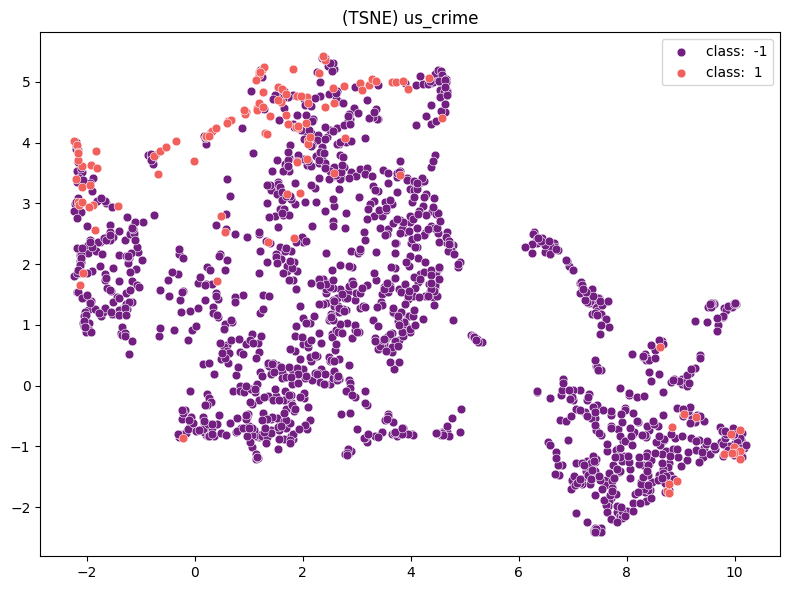


Class -1 has 1475 points.
Class 1 has 120 points.


 
 
+++ random - bagging


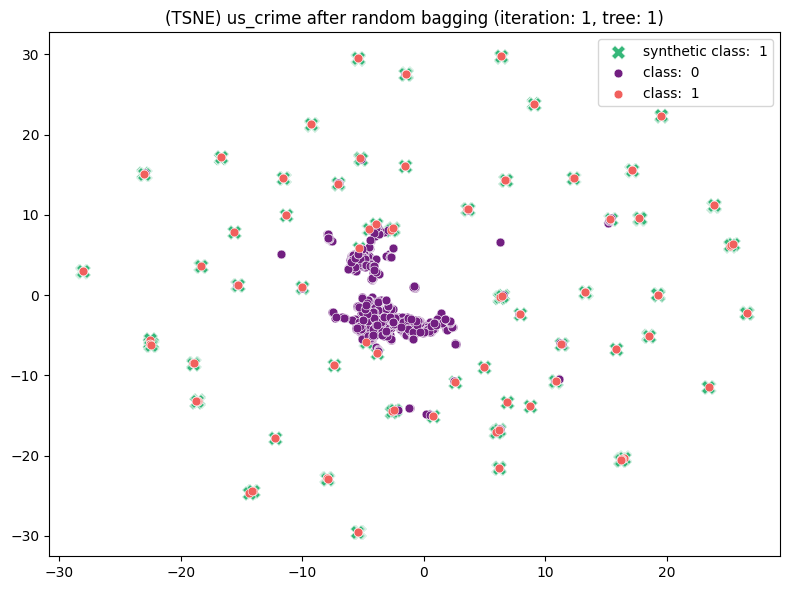


Class 0 has 1480 original samples and 0 synthetic samples after random bagging.
Class 1 has 115 original samples and 1365 synthetic samples after random bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9500       0.9500       0.9500       0.0000
           1       0.5789       0.5789       0.5789       0.0000

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9783       0.9783       0.9783       0.0000
           1       0.3667       0.3667       0.3667       0.0000

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9640       0.9640       0.9640       0.0000
           1       0.4490       0.4490       0.4490       0.0000

                      min          avg          max          std
 precision :       0.7645       0.7645       0.7645       0.0000

                      min          avg          max          std
    recall :       0.6725       0.6725       0.

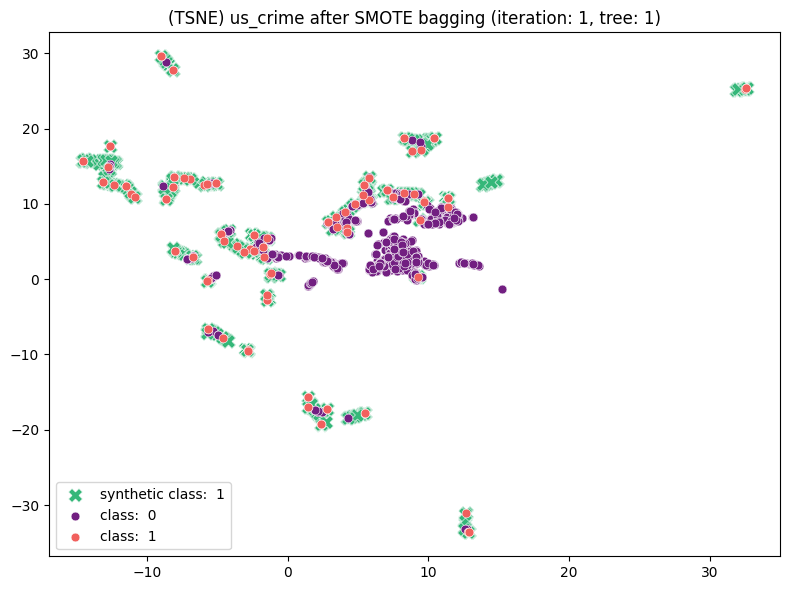


Class 0 has 1490 original samples and 0 synthetic samples after SMOTE bagging.
Class 1 has 105 original samples and 1385 synthetic samples after SMOTE bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9512       0.9536       0.9559       0.0033
           1       0.3889       0.3944       0.4000       0.0079

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9404       0.9458       0.9512       0.0077
           1       0.4000       0.4333       0.4667       0.0471

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9481       0.9497       0.9512       0.0022
           1       0.4000       0.4121       0.4242       0.0171

                      min          avg          max          std
 precision :       0.6724       0.6740       0.6756       0.0023

                      min          avg          max          std
    recall :       0.6756       0.6896       0.70

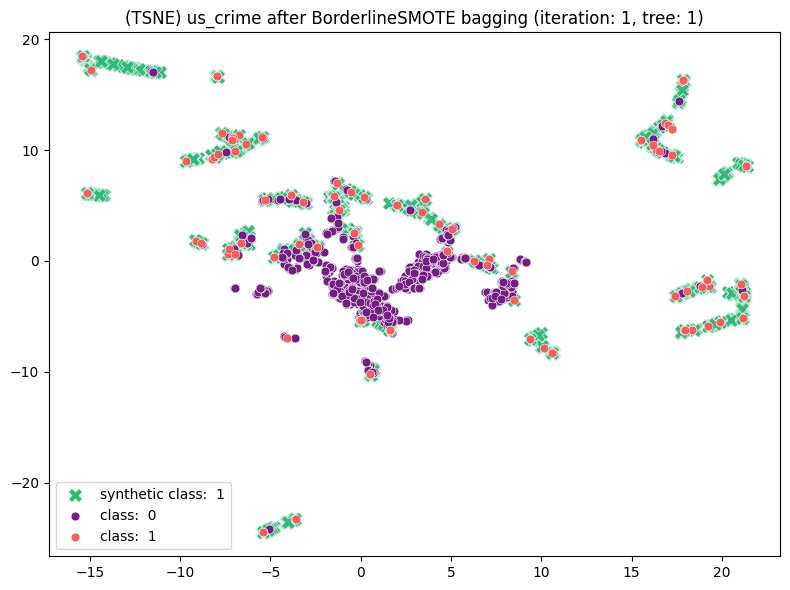


Class 0 has 1477 original samples and 0 synthetic samples after BorderlineSMOTE bagging.
Class 1 has 118 original samples and 1359 synthetic samples after BorderlineSMOTE bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9517       0.9528       0.9538       0.0015
           1       0.4194       0.4404       0.4615       0.0298

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9512       0.9566       0.9621       0.0077
           1       0.4000       0.4167       0.4333       0.0236

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9525       0.9547       0.9569       0.0031
           1       0.4262       0.4274       0.4286       0.0017

                      min          avg          max          std
 precision :       0.6866       0.6966       0.7066       0.0142

                      min          avg          max          std
    recall :       0.6810    

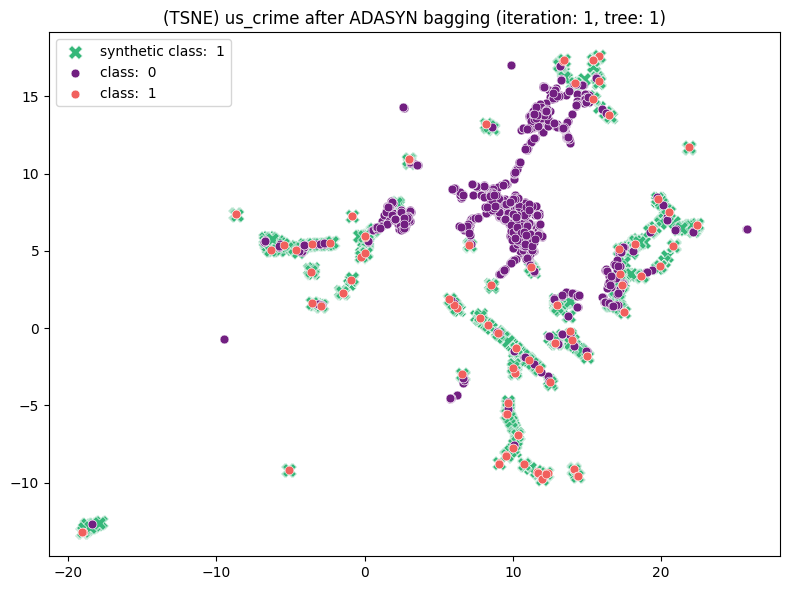


Class 0 has 1485 original samples and 0 synthetic samples after ADASYN bagging.
Class 1 has 110 original samples and 1381 synthetic samples after ADASYN bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9503       0.9573       0.9643       0.0099
           1       0.3243       0.4050       0.4857       0.1141

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9322       0.9417       0.9512       0.0134
           1       0.4000       0.4833       0.5667       0.1179

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9412       0.9494       0.9577       0.0117
           1       0.3582       0.4406       0.5231       0.1166

                      min          avg          max          std
 precision :       0.6373       0.6812       0.7250       0.0620

                      min          avg          max          std
    recall :       0.6661       0.7125       0.

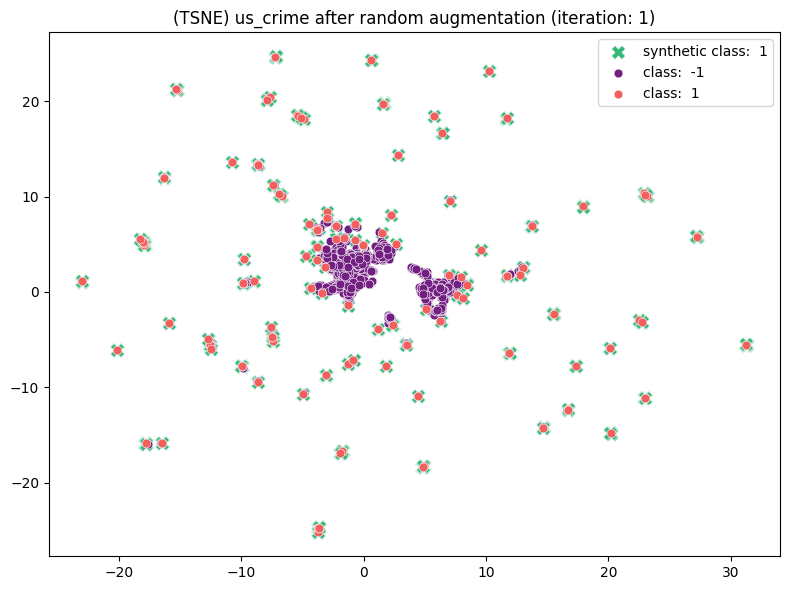


Class -1 has 1475 original points and 0 synthetic points after random augmentation.
Class 1 has 120 original points and 1355 synthetic points after random augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9465       0.9479       0.9493       0.0020
           1       0.4000       0.4292       0.4583       0.0412

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9593       0.9621       0.9648       0.0038
           1       0.3333       0.3500       0.3667       0.0236

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9529       0.9549       0.9570       0.0029
           1       0.3636       0.3855       0.4074       0.0310

                      min          avg          max          std
 precision :       0.6733       0.6885       0.7038       0.0216

                      min          avg          max          std
    recall :       0.6463       0.6560  

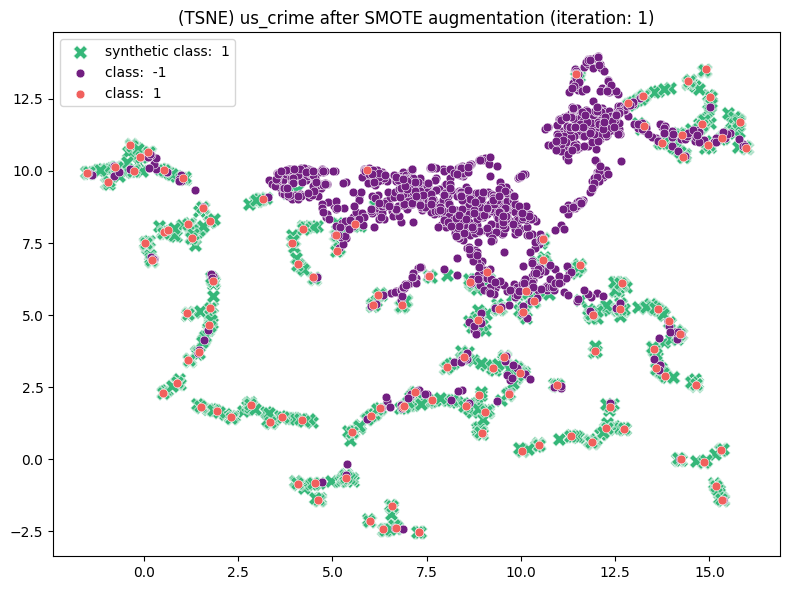


Class -1 has 1475 original points and 0 synthetic points after SMOTE augmentation.
Class 1 has 120 original points and 1355 synthetic points after SMOTE augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9583       0.9584       0.9586       0.0002
           1       0.3846       0.3950       0.4054       0.0147

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9350       0.9377       0.9404       0.0038
           1       0.5000       0.5000       0.5000       0.0000

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9465       0.9479       0.9494       0.0020
           1       0.4348       0.4413       0.4478       0.0092

                      min          avg          max          std
 precision :       0.6715       0.6767       0.6820       0.0074

                      min          avg          max          std
    recall :       0.7175       0.7188    

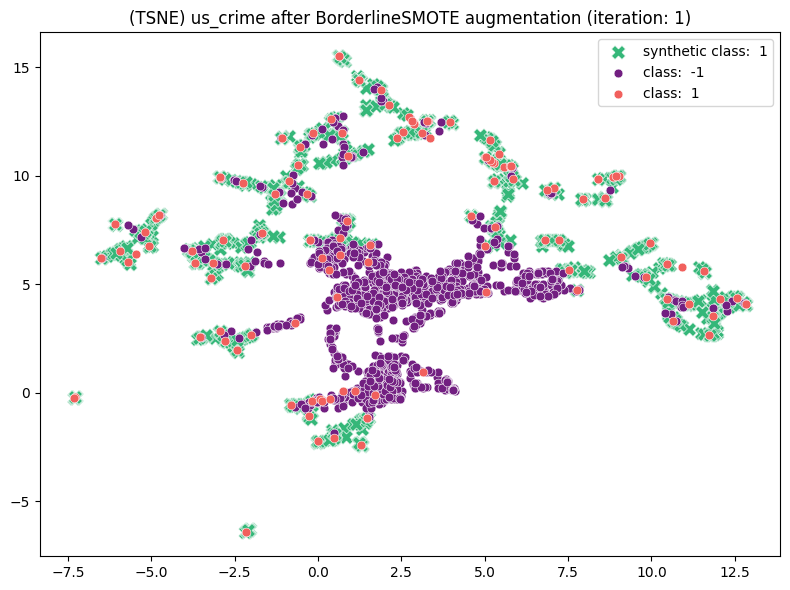


Class -1 has 1475 original points and 0 synthetic points after BorderlineSMOTE augmentation.
Class 1 has 120 original points and 1355 synthetic points after BorderlineSMOTE augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9510       0.9523       0.9536       0.0018
           1       0.3750       0.3845       0.3939       0.0134

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9458       0.9458       0.9458       0.0000
           1       0.4000       0.4167       0.4333       0.0236

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9484       0.9490       0.9497       0.0009
           1       0.3871       0.3999       0.4127       0.0181

                      min          avg          max          std
 precision :       0.6630       0.6684       0.6737       0.0076

                      min          avg          max          std
    recall :       0.6

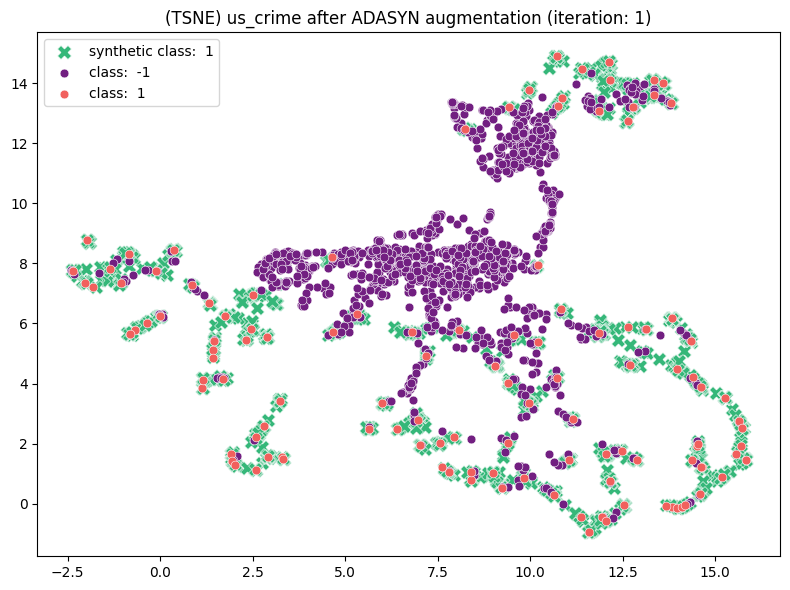


Class -1 has 1475 original points and 0 synthetic points after ADASYN augmentation.
Class 1 has 120 original points and 1350 synthetic points after ADASYN augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9528       0.9553       0.9579       0.0036
           1       0.3333       0.3411       0.3488       0.0110

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9241       0.9268       0.9295       0.0038
           1       0.4333       0.4667       0.5000       0.0471

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9407       0.9409       0.9410       0.0002
           1       0.3768       0.3939       0.4110       0.0241

                      min          avg          max          std
 precision :       0.6431       0.6482       0.6534       0.0073

                      min          avg          max          std
    recall :       0.6814       0.6967  

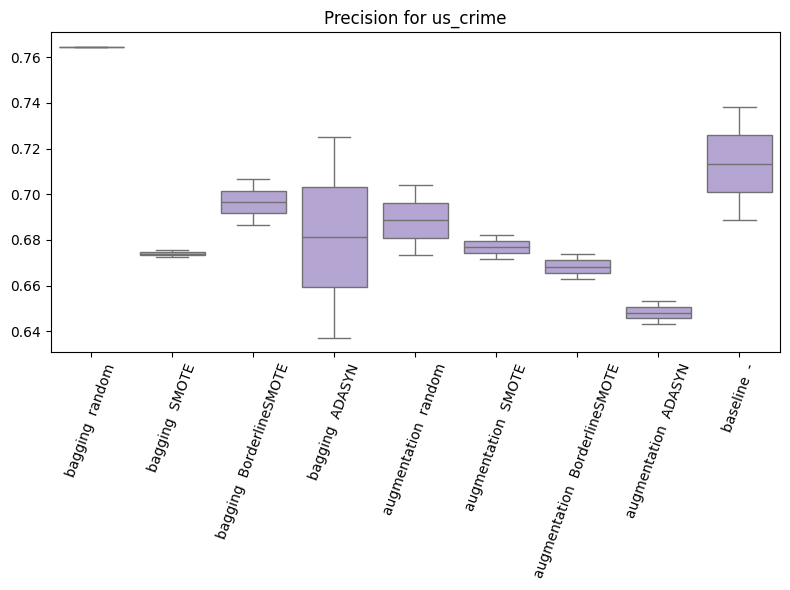

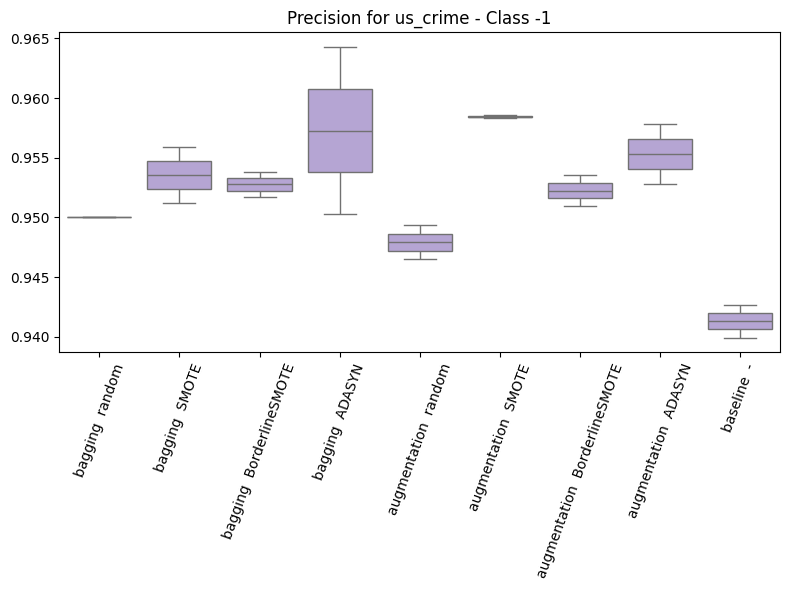

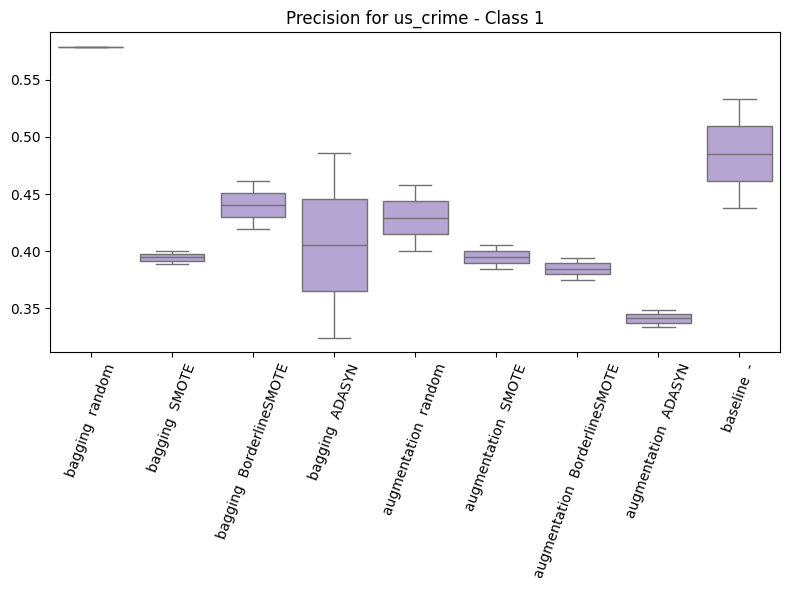

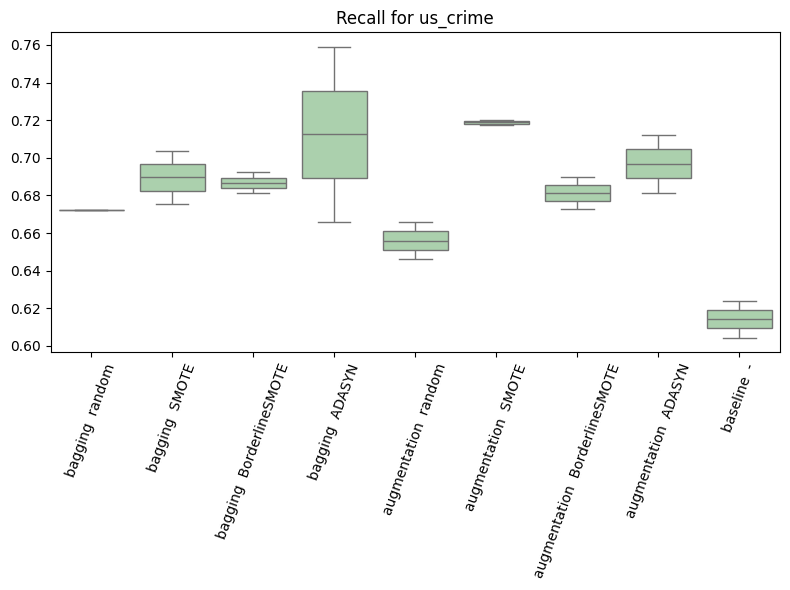

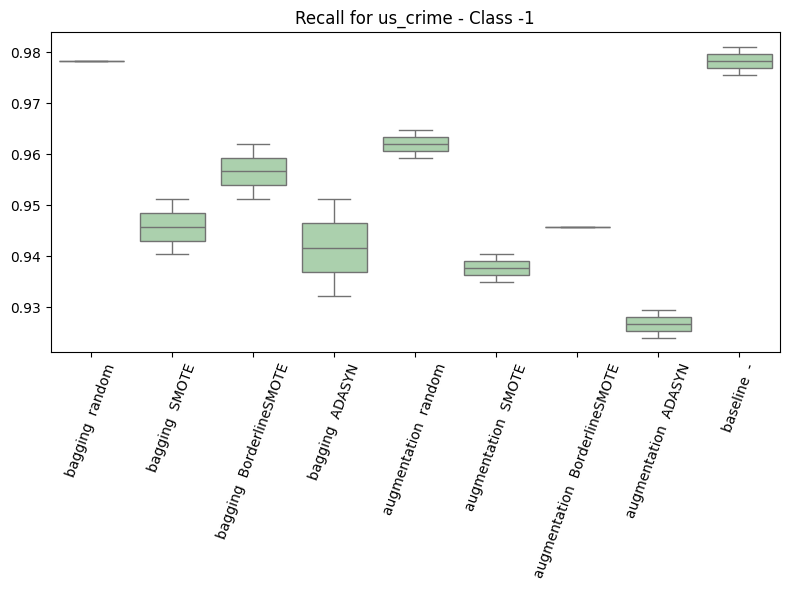

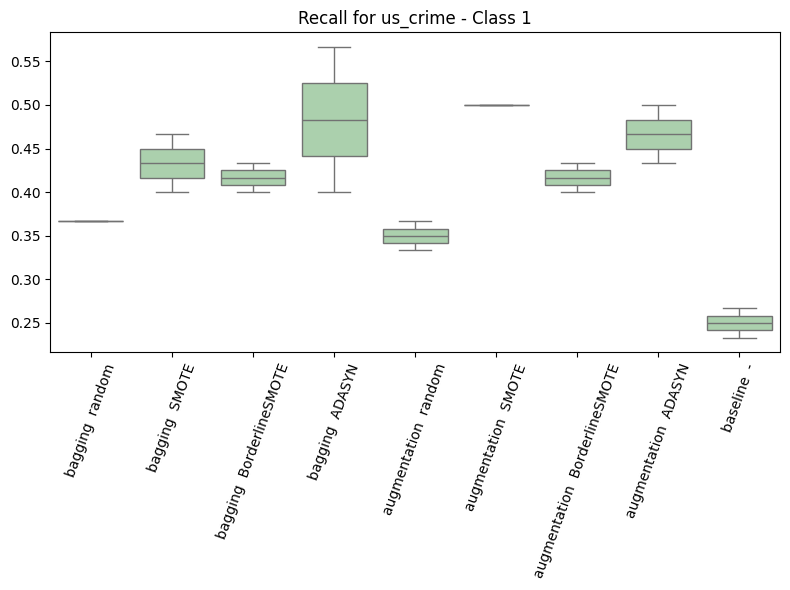

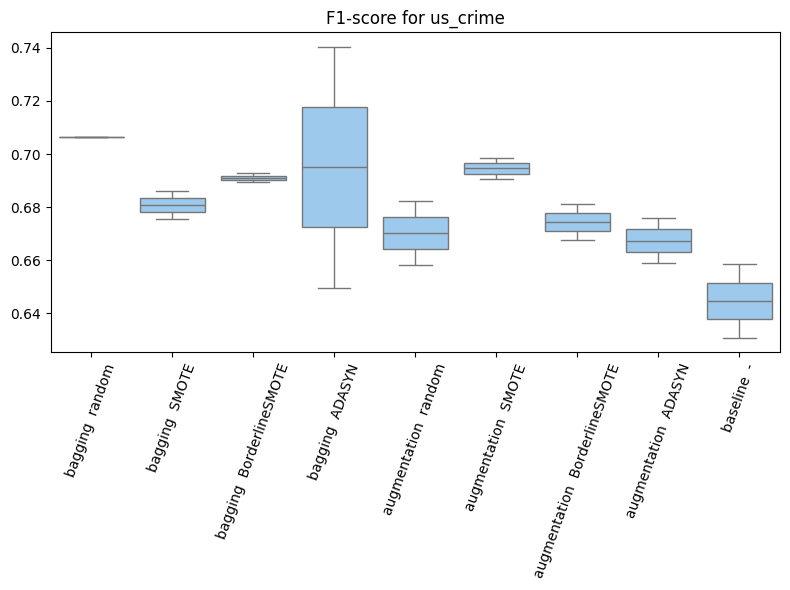

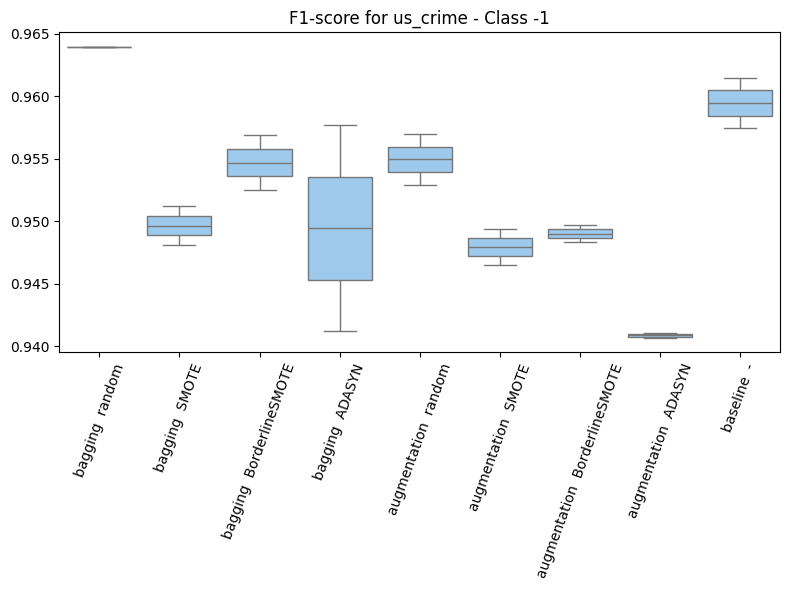

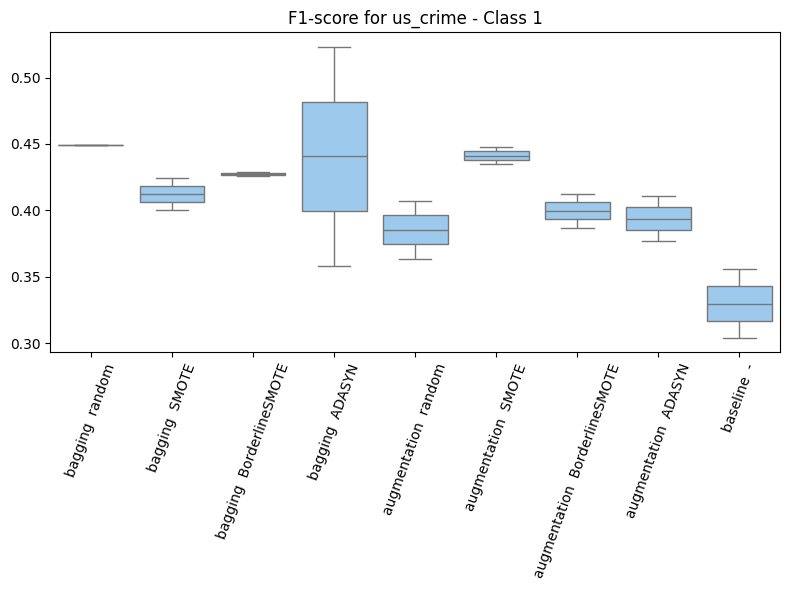

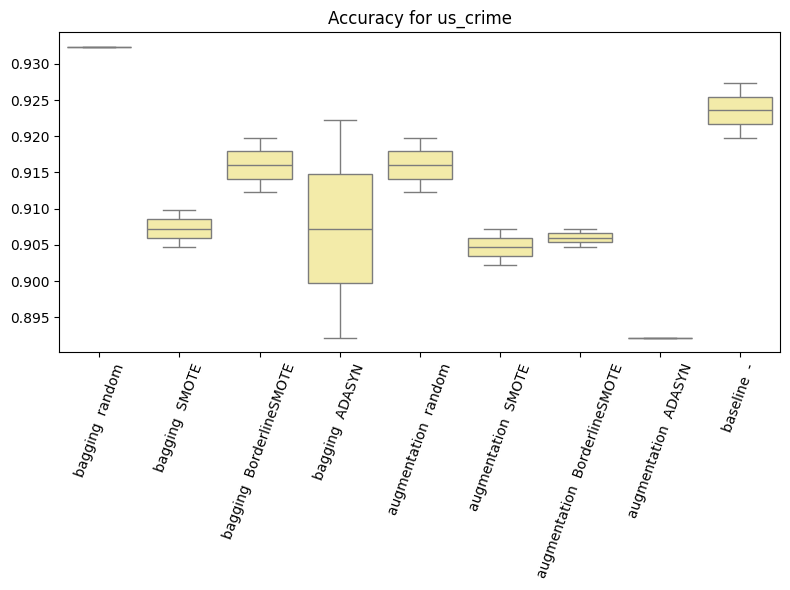

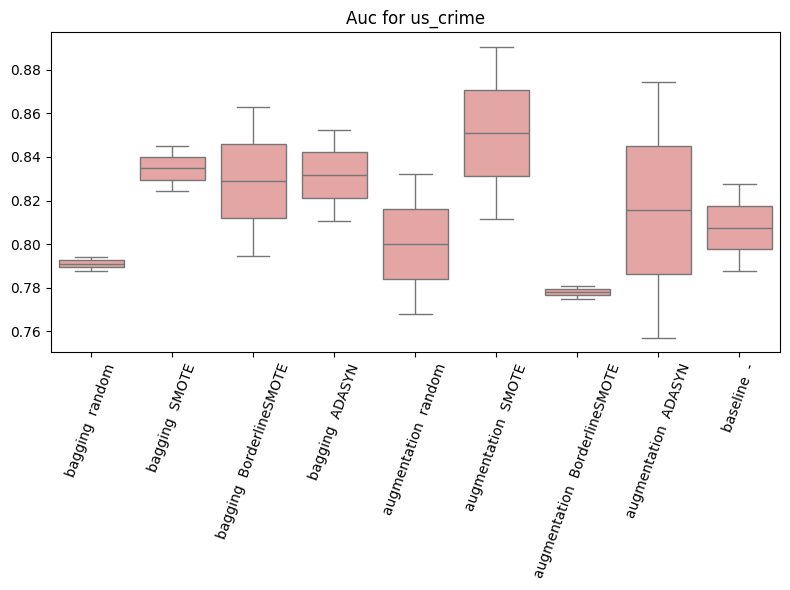

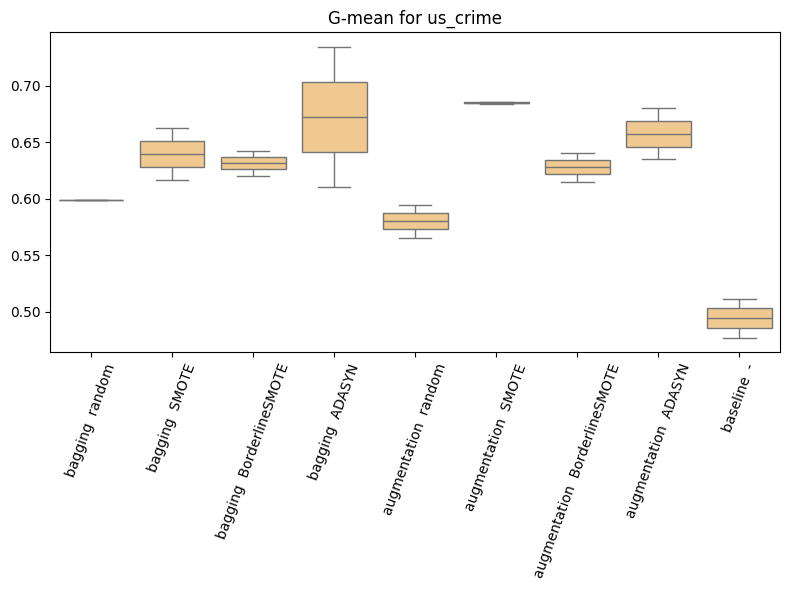

*****  DATASET: letter_img



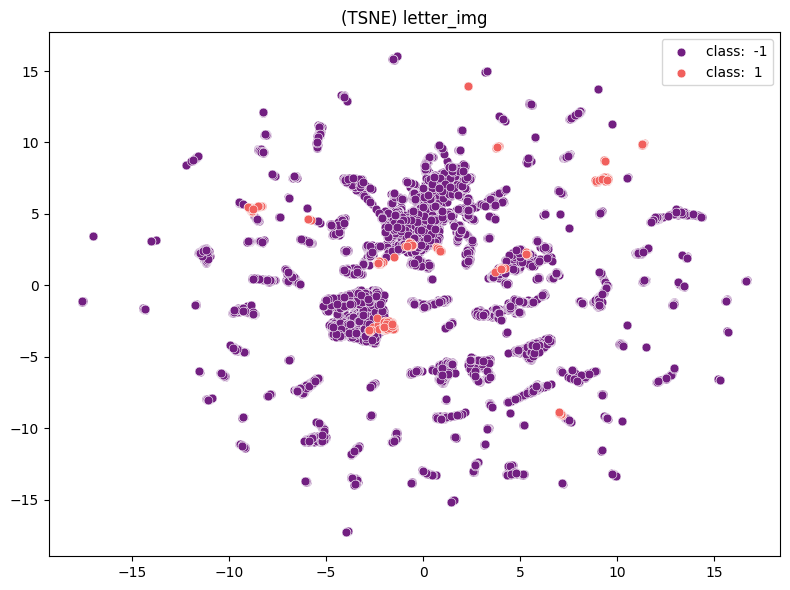


Class -1 has 15413 points.
Class 1 has 587 points.


 
 
+++ random - bagging


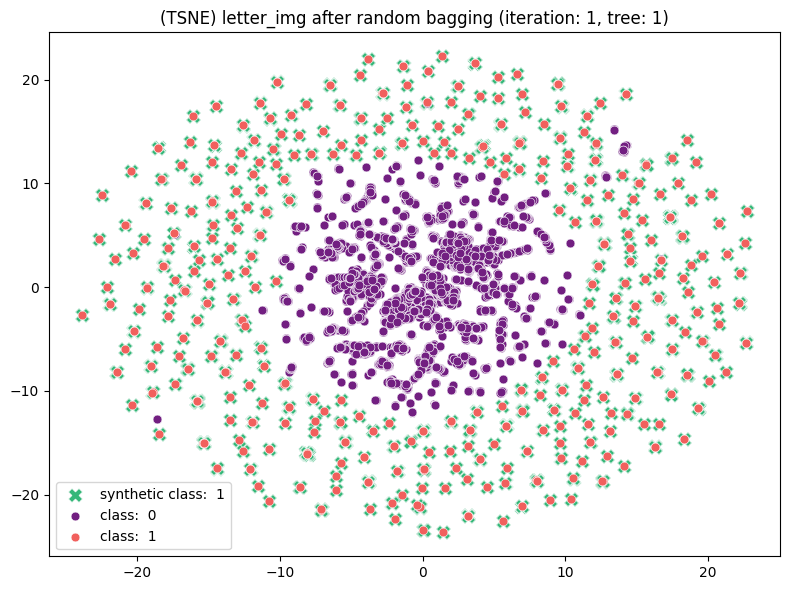


Class 0 has 15424 original samples and 0 synthetic samples after random bagging.
Class 1 has 576 original samples and 14848 synthetic samples after random bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9951       0.9952       0.9954       0.0002
           1       1.0000       1.0000       1.0000       0.0000

               min_recall   avg_recall   max_recall   std_recall
          -1       1.0000       1.0000       1.0000       0.0000
           1       0.8707       0.8741       0.8776       0.0048

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9975       0.9976       0.9977       0.0001
           1       0.9309       0.9328       0.9348       0.0027

                      min          avg          max          std
 precision :       0.9975       0.9976       0.9977       0.0001

                      min          avg          max          std
    recall :       0.9354       0.9371       

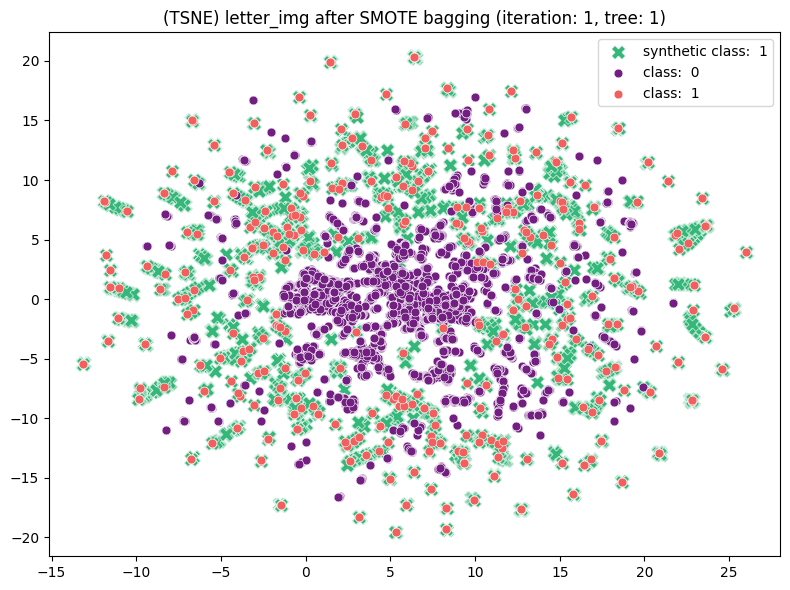


Class 0 has 15413 original samples and 0 synthetic samples after SMOTE bagging.
Class 1 has 587 original samples and 14826 synthetic samples after SMOTE bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9953       0.9957       0.9961       0.0005
           1       0.9773       0.9812       0.9851       0.0055

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9992       0.9994       0.9995       0.0002
           1       0.8776       0.8878       0.8980       0.0144

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9973       0.9975       0.9978       0.0004
           1       0.9247       0.9321       0.9395       0.0104

                      min          avg          max          std
 precision :       0.9863       0.9885       0.9906       0.0030

                      min          avg          max          std
    recall :       0.9384       0.9436       0.

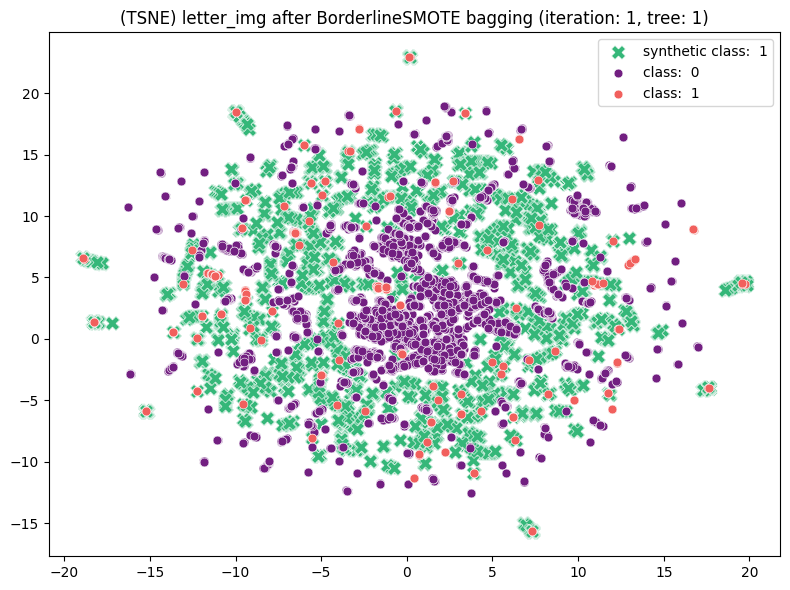


Class 0 has 15423 original samples and 0 synthetic samples after BorderlineSMOTE bagging.
Class 1 has 577 original samples and 14846 synthetic samples after BorderlineSMOTE bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9953       0.9955       0.9956       0.0002
           1       0.9923       0.9923       0.9924       0.0000

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9997       0.9997       0.9997       0.0000
           1       0.8776       0.8810       0.8844       0.0048

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9975       0.9976       0.9977       0.0001
           1       0.9314       0.9333       0.9353       0.0027

                      min          avg          max          std
 precision :       0.9938       0.9939       0.9940       0.0001

                      min          avg          max          std
    recall :       0.9386  

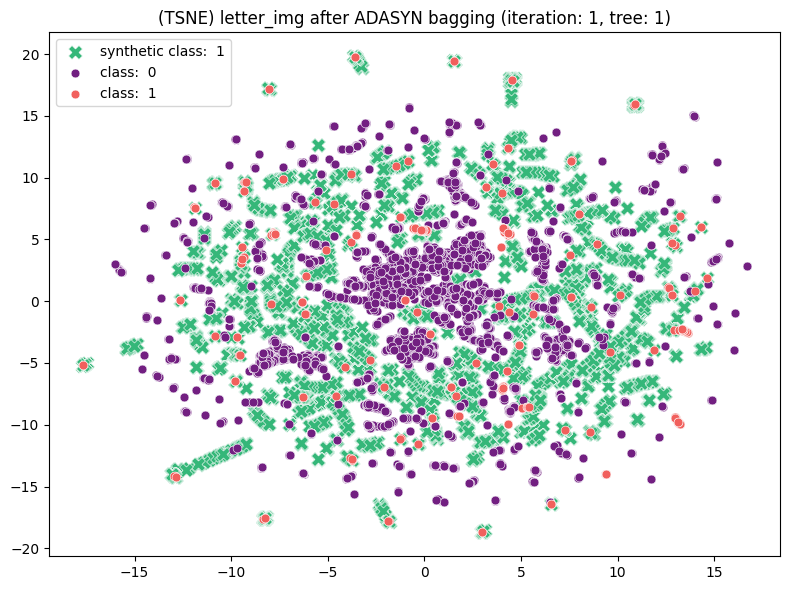


Class 0 has 15423 original samples and 0 synthetic samples after ADASYN bagging.
Class 1 has 577 original samples and 14855 synthetic samples after ADASYN bagging.


             min_precision avg_precision max_precision std_precision
          -1       0.9941       0.9952       0.9964       0.0016
           1       0.9779       0.9890       1.0000       0.0156

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9992       0.9996       1.0000       0.0006
           1       0.8435       0.8741       0.9048       0.0433

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9970       0.9974       0.9978       0.0005
           1       0.9151       0.9275       0.9399       0.0175

                      min          avg          max          std
 precision :       0.9872       0.9921       0.9970       0.0070

                      min          avg          max          std
    recall :       0.9218       0.9369       

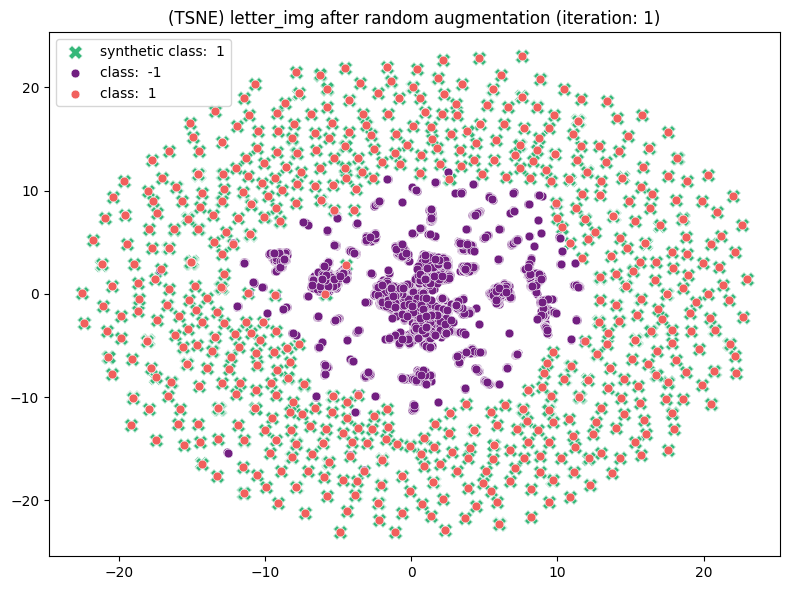


Class -1 has 15413 original points and 0 synthetic points after random augmentation.
Class 1 has 587 original points and 14826 synthetic points after random augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9961       0.9964       0.9966       0.0004
           1       0.9853       0.9889       0.9925       0.0051

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9995       0.9996       0.9997       0.0002
           1       0.8980       0.9048       0.9116       0.0096

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9979       0.9980       0.9981       0.0001
           1       0.9429       0.9449       0.9470       0.0029

                      min          avg          max          std
 precision :       0.9910       0.9926       0.9943       0.0024

                      min          avg          max          std
    recall :       0.9488       0.9522

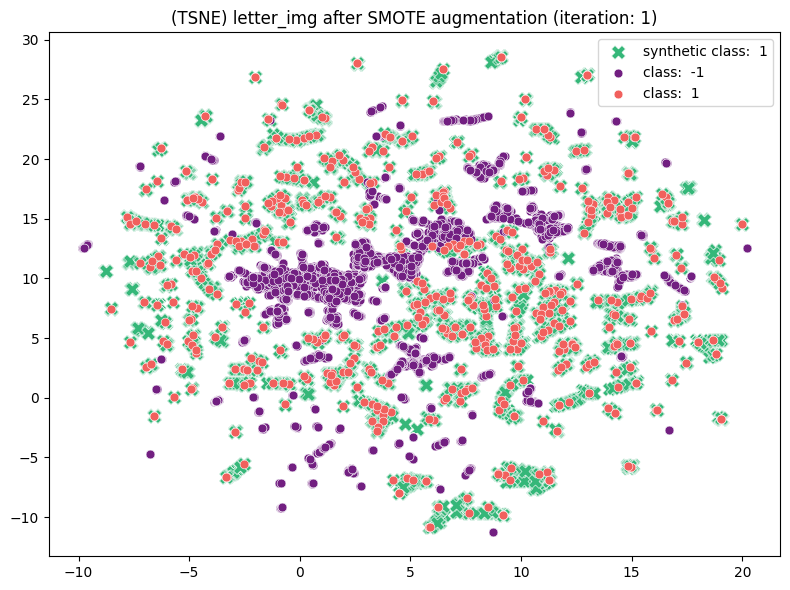


Class -1 has 15413 original points and 0 synthetic points after SMOTE augmentation.
Class 1 has 587 original points and 14826 synthetic points after SMOTE augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9951       0.9956       0.9961       0.0007
           1       0.9565       0.9668       0.9771       0.0146

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9984       0.9988       0.9992       0.0006
           1       0.8707       0.8844       0.8980       0.0192

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9972       0.9972       0.9973       0.0001
           1       0.9209       0.9236       0.9263       0.0039

                      min          avg          max          std
 precision :       0.9763       0.9812       0.9861       0.0069

                      min          avg          max          std
    recall :       0.9350       0.9416  

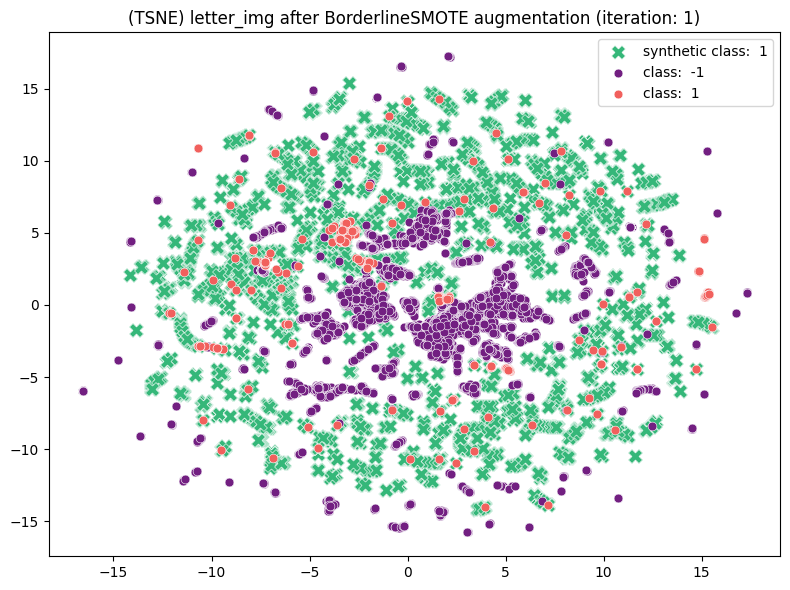


Class -1 has 15413 original points and 0 synthetic points after BorderlineSMOTE augmentation.
Class 1 has 587 original points and 14826 synthetic points after BorderlineSMOTE augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9946       0.9947       0.9948       0.0002
           1       0.9769       0.9806       0.9844       0.0053

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9992       0.9994       0.9995       0.0002
           1       0.8571       0.8605       0.8639       0.0048

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9970       0.9970       0.9970       0.0000
           1       0.9164       0.9167       0.9170       0.0004

                      min          avg          max          std
 precision :       0.9859       0.9877       0.9895       0.0025

                      min          avg          max          std
    recall :       0

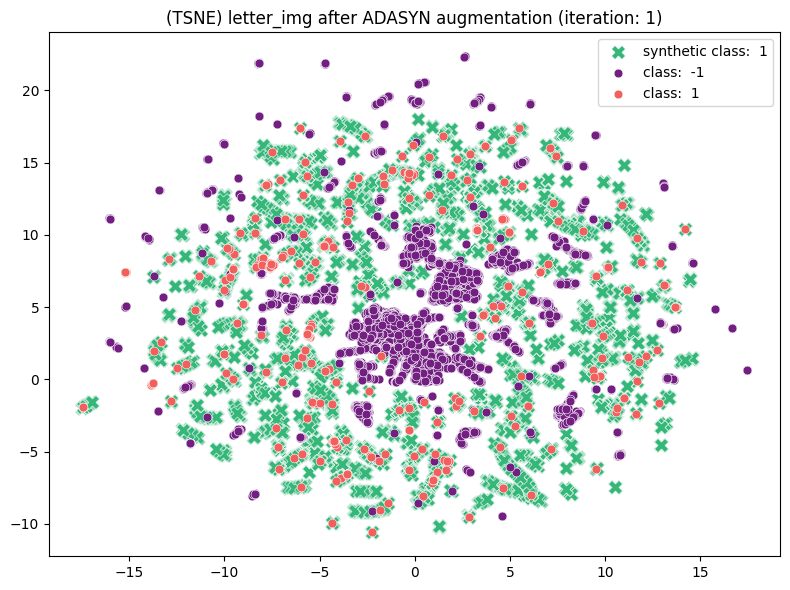


Class -1 has 15413 original points and 0 synthetic points after ADASYN augmentation.
Class 1 has 587 original points and 14844 synthetic points after ADASYN augmentation.


             min_precision avg_precision max_precision std_precision
          -1       0.9936       0.9942       0.9948       0.0009
           1       0.9845       0.9882       0.9919       0.0052

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9995       0.9996       0.9997       0.0002
           1       0.8299       0.8469       0.8639       0.0241

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.9966       0.9969       0.9972       0.0004
           1       0.9037       0.9120       0.9203       0.0117

                      min          avg          max          std
 precision :       0.9897       0.9912       0.9927       0.0022

                      min          avg          max          std
    recall :       0.9148       0.9233

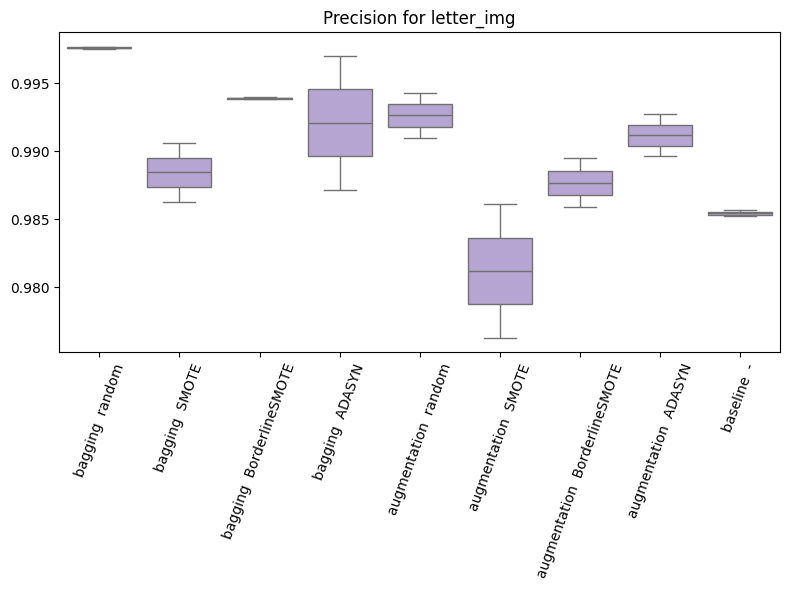

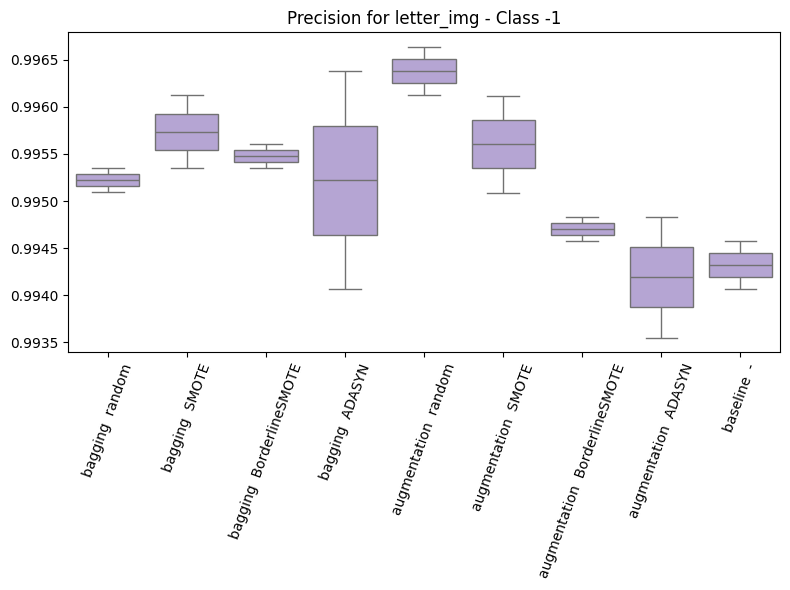

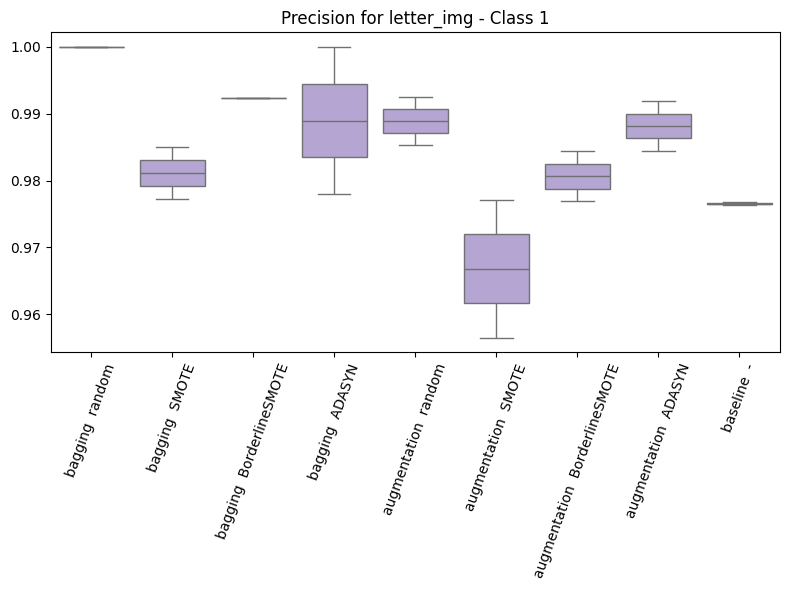

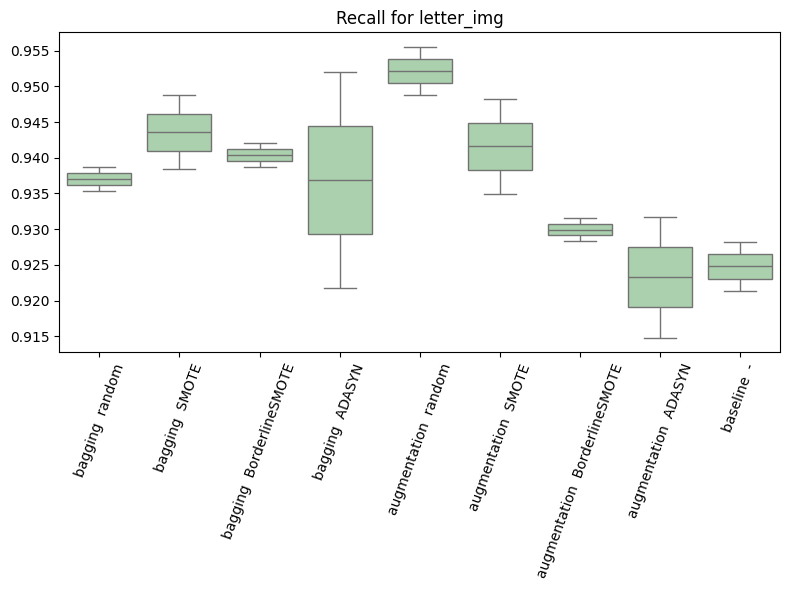

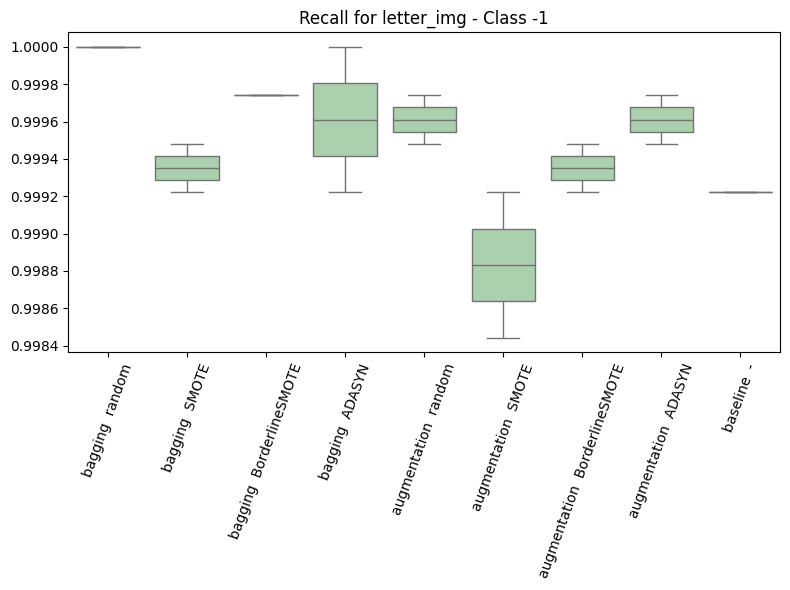

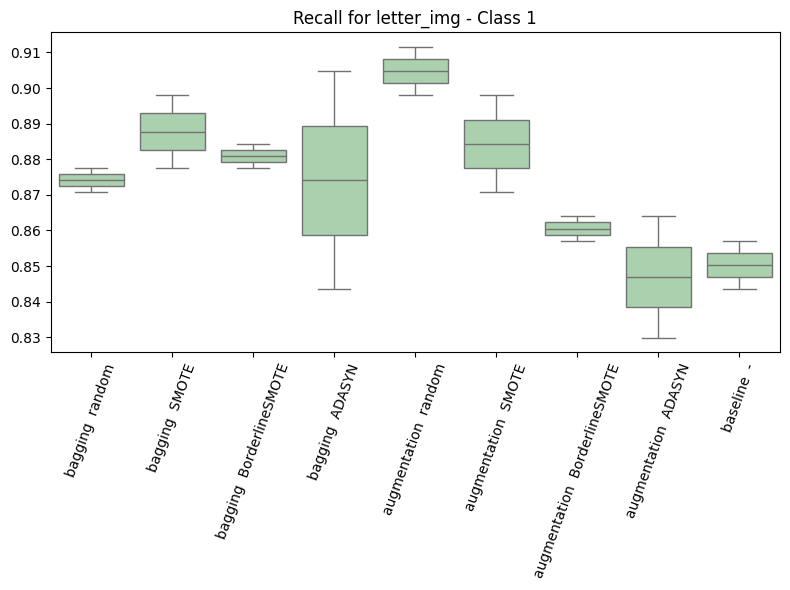

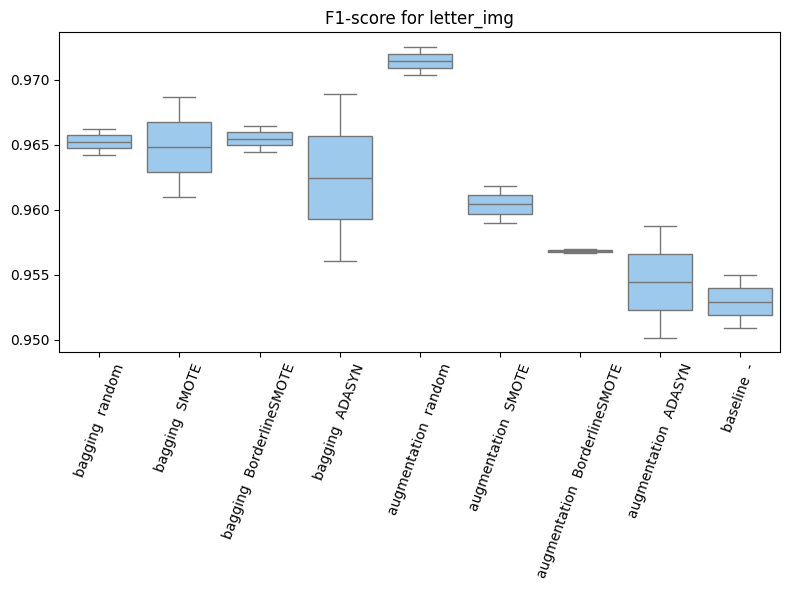

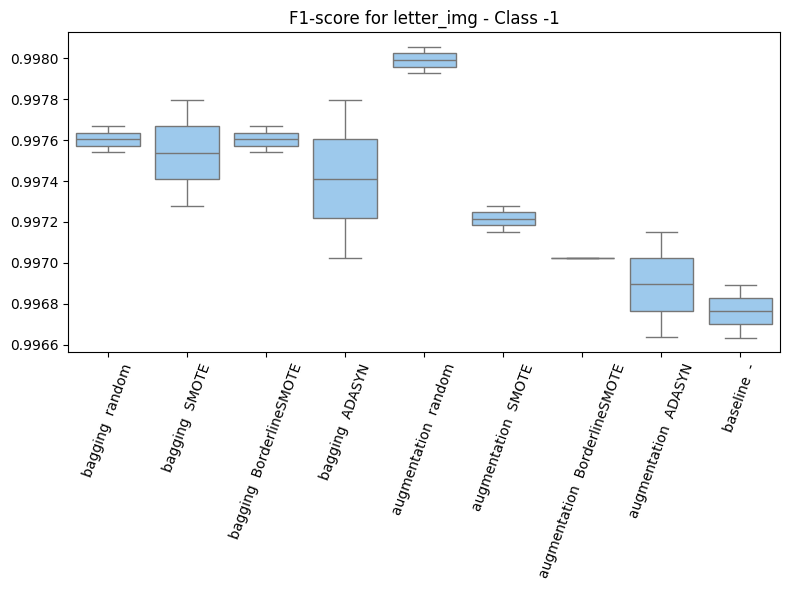

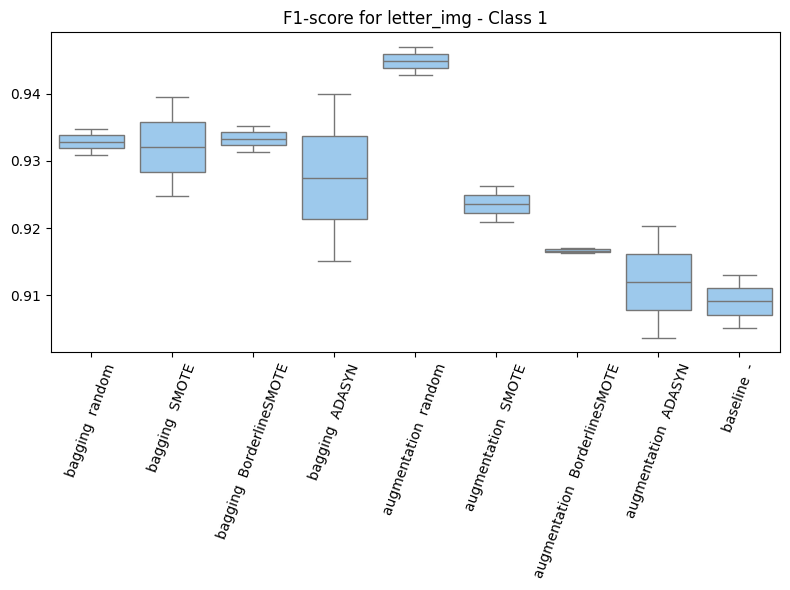

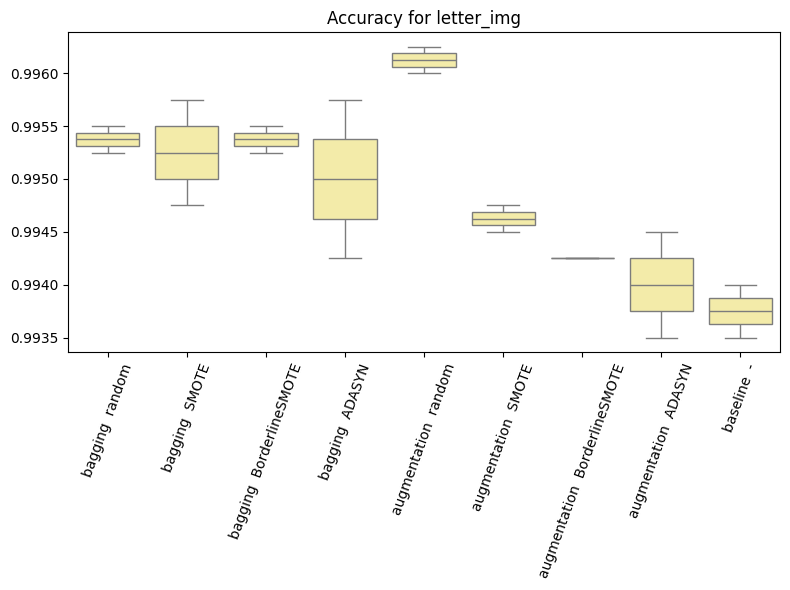

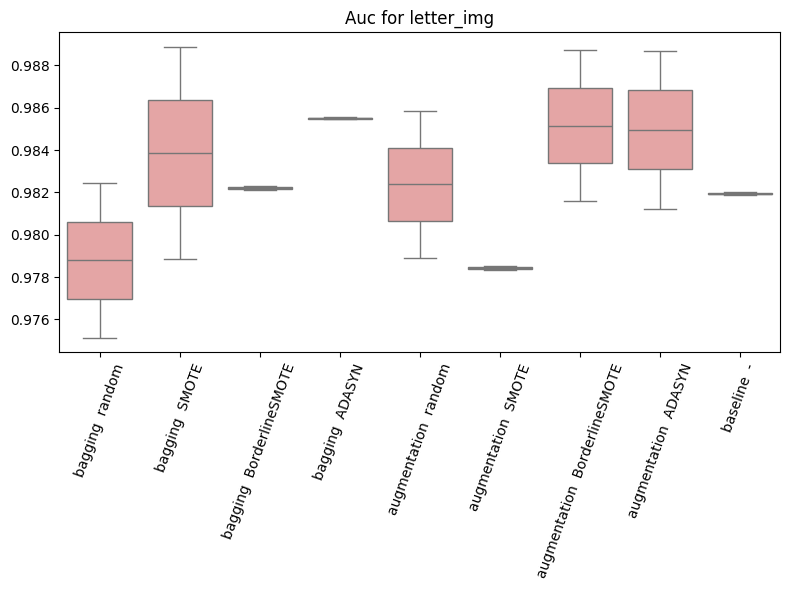

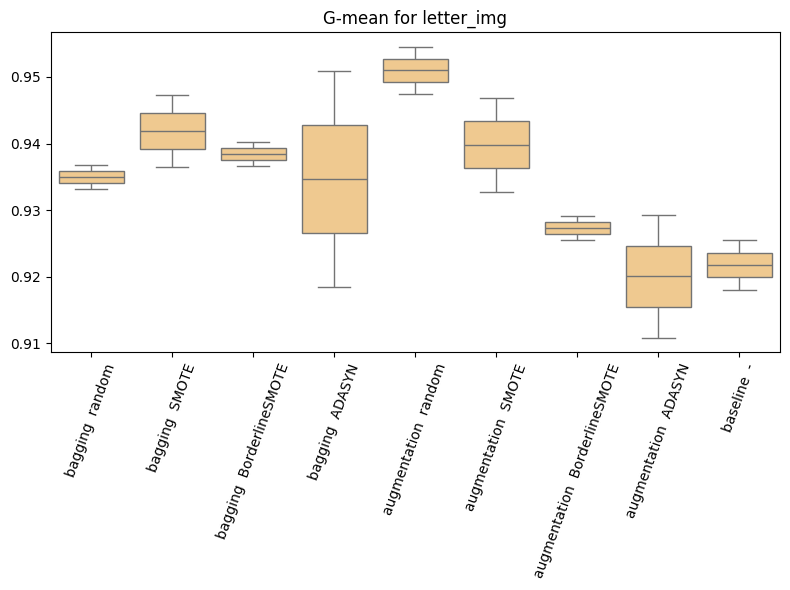

In [33]:
comparator1.summary()

In [76]:
comparator = Comparator()
comparator.compute()

=========================     START COMPUTING     =======================

Mode: both
Iterations: 100
Oversampling strategies: ['random', 'SMOTE', 'BorderlineSMOTE', 'ADASYN']
Metrics: ['precision', 'recall', 'f1-score', 'accuracy']
Number of trees: 100
Datasets: ['us_crime', 'letter_img']

 
 + DATASET: us_crime

-=-=-=-=-=-=   BAGGING   =-=-=-=-=-
random - bagging |██████████████████████████████| 100.0% Complete
SMOTE - bagging |██████████████████████████████| 100.0% Complete
BorderlineSMOTE - bagging |██████████████████████████████| 100.0% Complete
ADASYN - bagging |██████████████████████████████| 100.0% Complete

-=-=-=-=-=-=   AUGMENTATION   =-=-=-=-=-
random - augmentation |██████████████████████████████| 100.0% Complete
SMOTE - augmentation |██████████████████████████████| 100.0% Complete
BorderlineSMOTE - augmentation |██████████████████████████████| 100.0% Complete
ADASYN - augmentation |██████████████████████████████| 100.0% Complete

-=-=-=-=-=-=   BASELINE   =-=-=-=-=-
base


=========================         SUMMARY         =======================

*****  DATASET: us_crime


 
 
+++ random - bagging


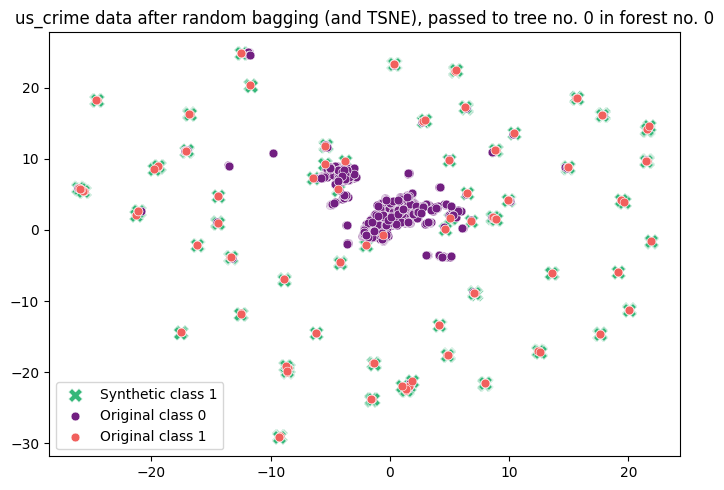


Class 0 has 1461 original samples and 0 synthetic samples after random oversampling.
Class 1 has 134 original samples and 1327 synthetic samples after random oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9313       0.9444       0.9577       0.0051
           1       0.9756       0.9893       0.9973       0.0054

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9563       0.9663       0.9748       0.0037
           1       0.3846       0.6905       0.9231       0.1142

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.1000       0.2830       0.4667       0.0695
           1       0.1667       0.3969       0.5652       0.0804

    Accuracy          min          avg          max          std
                   0.9173       0.9362       0.9524       0.0069

 
 
+++ SMOTE - bagging


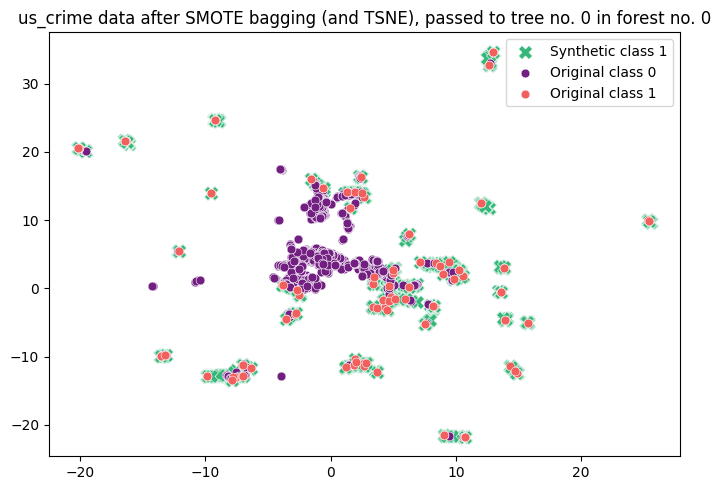


Class 0 has 1464 original samples and 0 synthetic samples after SMOTE oversampling.
Class 1 has 131 original samples and 1333 synthetic samples after SMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9373       0.9558       0.9754       0.0066
           1       0.9539       0.9720       0.9946       0.0084

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9489       0.9638       0.9761       0.0054
           1       0.3333       0.5703       0.8750       0.0930

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.2000       0.4470       0.7000       0.0862
           1       0.2609       0.4973       0.6667       0.0776

    Accuracy          min          avg          max          std
                   0.9048       0.9326       0.9549       0.0100

 
 
+++ BorderlineSMOTE - bagging


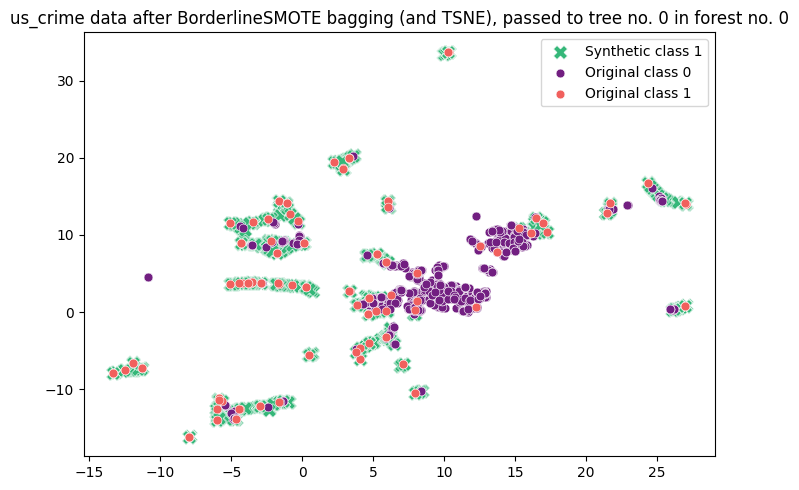


Class 0 has 1470 original samples and 0 synthetic samples after BorderlineSMOTE oversampling.
Class 1 has 125 original samples and 1345 synthetic samples after BorderlineSMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9420       0.9554       0.9704       0.0063
           1       0.9539       0.9738       0.9946       0.0086

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9528       0.9645       0.9786       0.0052
           1       0.4000       0.5838       0.8750       0.0914

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.2667       0.4400       0.6333       0.0837
           1       0.3200       0.4976       0.6923       0.0755

    Accuracy          min          avg          max          std
                   0.9123       0.9337       0.9599       0.0095

 
 
+++ ADASYN - bagging


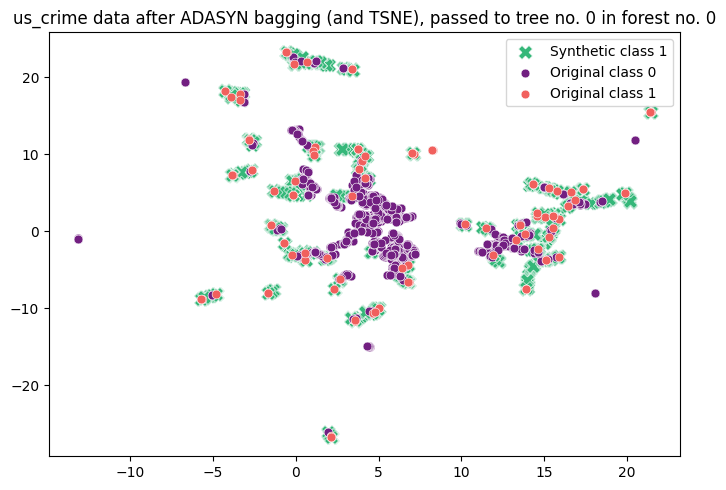


Class 0 has 1488 original samples and 0 synthetic samples after ADASYN oversampling.
Class 1 has 107 original samples and 1383 synthetic samples after ADASYN oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9395       0.9555       0.9754       0.0069
           1       0.9458       0.9705       0.9892       0.0091

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9484       0.9629       0.9746       0.0056
           1       0.3684       0.5550       0.7895       0.0918

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.2333       0.4433       0.7000       0.0909
           1       0.2857       0.4889       0.6667       0.0803

    Accuracy          min          avg          max          std
                   0.9048       0.9309       0.9524       0.0104

 
+++ random - augmentation +++


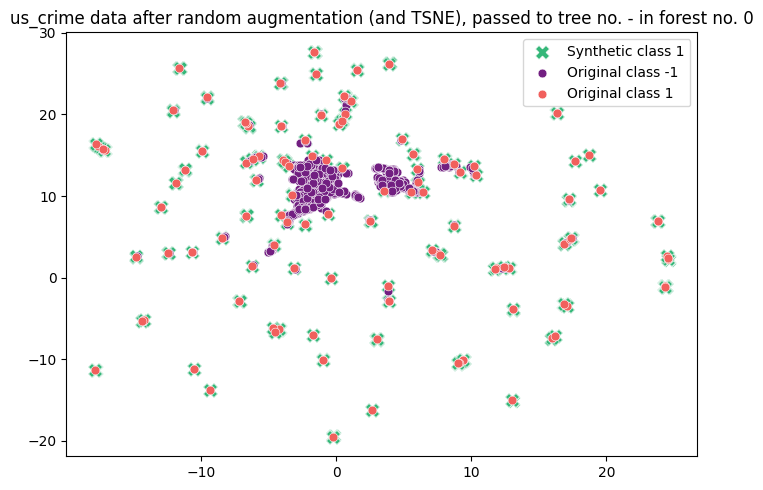


Class -1 has 1475 original samples and 0 synthetic samples after random oversampling.
Class 1 has 120 original samples and 1355 synthetic samples after random oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9349       0.9522       0.9677       0.0066
           1       0.9593       0.9769       0.9973       0.0077

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9492       0.9644       0.9761       0.0053
           1       0.3000       0.5873       0.9286       0.1025

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.1667       0.3963       0.6000       0.0868
           1       0.2222       0.4693       0.6415       0.0853

    Accuracy          min          avg          max          std
                   0.9048       0.9333       0.9549       0.0099

 
+++ SMOTE - augmentation +++


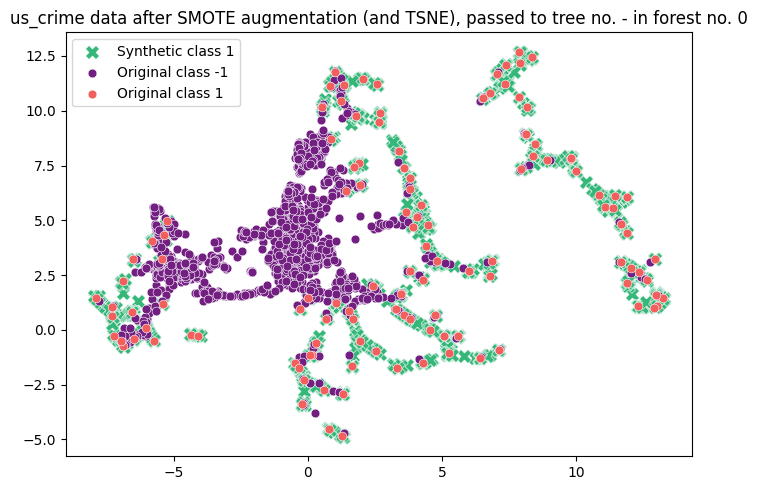


Class -1 has 1475 original samples and 0 synthetic samples after SMOTE oversampling.
Class 1 has 120 original samples and 1355 synthetic samples after SMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9455       0.9617       0.9780       0.0069
           1       0.9187       0.9537       0.9756       0.0109

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9399       0.9576       0.9714       0.0063
           1       0.3056       0.4868       0.6286       0.0682

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.3333       0.5317       0.7333       0.0885
           1       0.3226       0.5052       0.6769       0.0667

    Accuracy          min          avg          max          std
                   0.8897       0.9220       0.9474       0.0113

 
+++ BorderlineSMOTE - augmentation +++


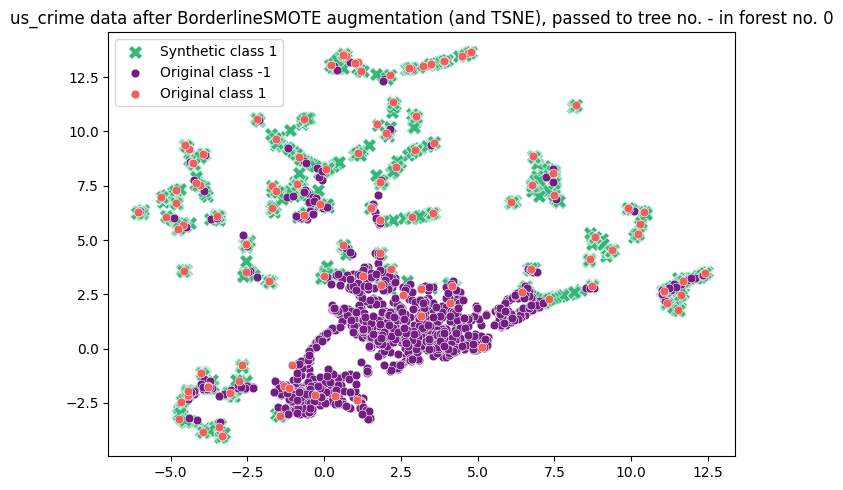


Class -1 has 1475 original samples and 0 synthetic samples after BorderlineSMOTE oversampling.
Class 1 has 120 original samples and 1355 synthetic samples after BorderlineSMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9410       0.9594       0.9749       0.0067
           1       0.9295       0.9581       0.9810       0.0109

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9410       0.9587       0.9705       0.0060
           1       0.3077       0.4971       0.6818       0.0723

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.2667       0.5003       0.7000       0.0872
           1       0.2857       0.4951       0.6230       0.0684

    Accuracy          min          avg          max          std
                   0.8922       0.9237       0.9449       0.0108

 
+++ ADASYN - augmentation +++


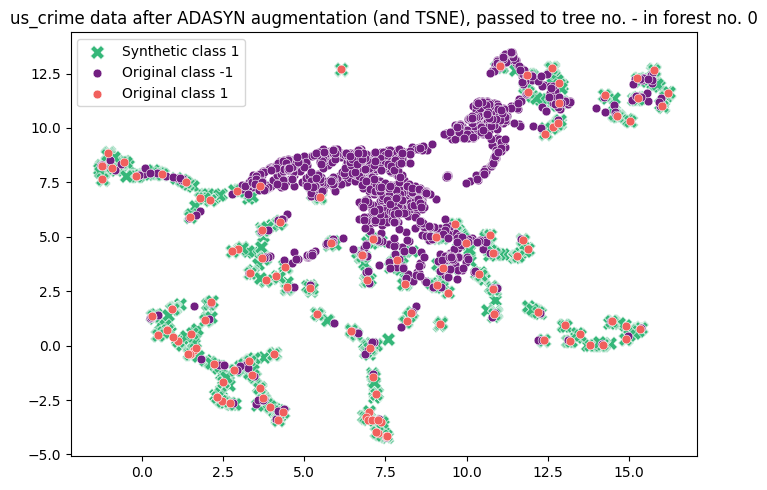


Class -1 has 1475 original samples and 0 synthetic samples after ADASYN oversampling.
Class 1 has 120 original samples and 1341 synthetic samples after ADASYN oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9429       0.9612       0.9777       0.0067
           1       0.9187       0.9511       0.9756       0.0111

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9404       0.9561       0.9688       0.0065
           1       0.2903       0.4706       0.6129       0.0675

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.3000       0.5267       0.7333       0.0855
           1       0.2951       0.4943       0.6286       0.0663

    Accuracy          min          avg          max          std
                   0.8922       0.9192       0.9424       0.0117

             min_precision avg_precision max_precision std_precision
          -1       0.9337       

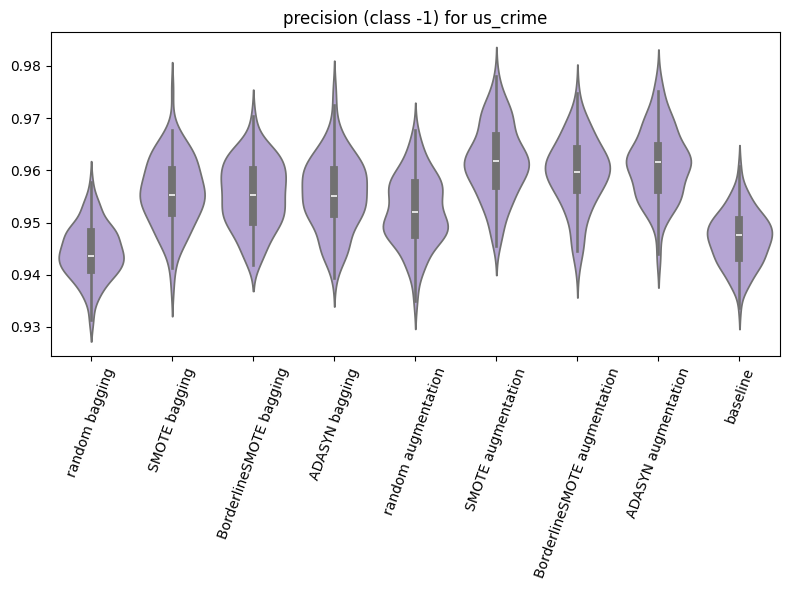

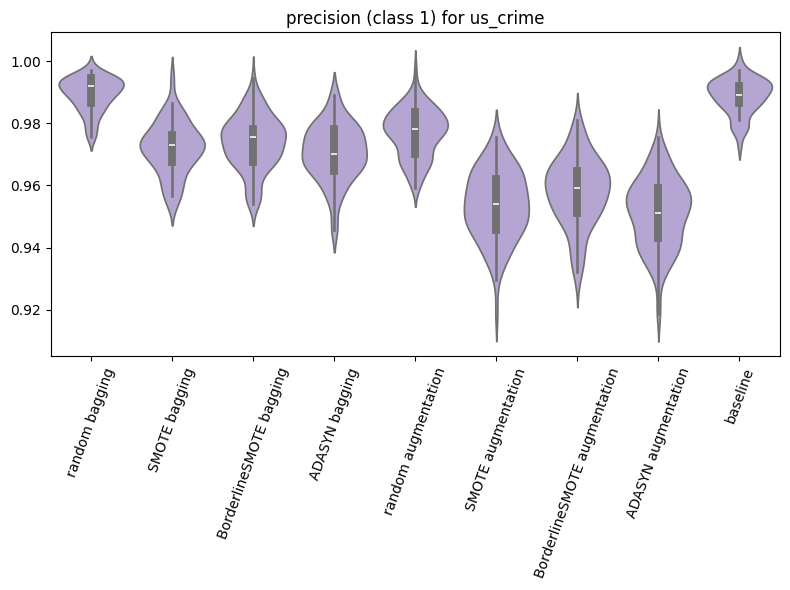

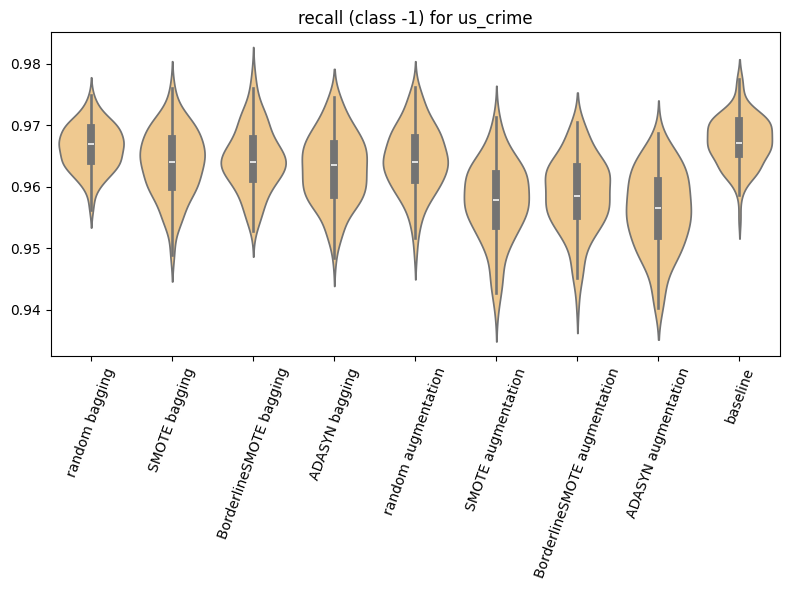

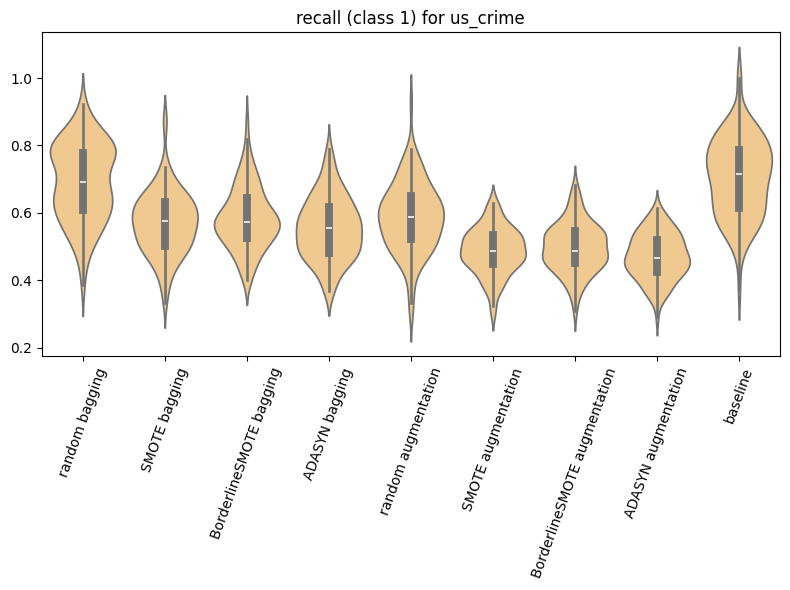

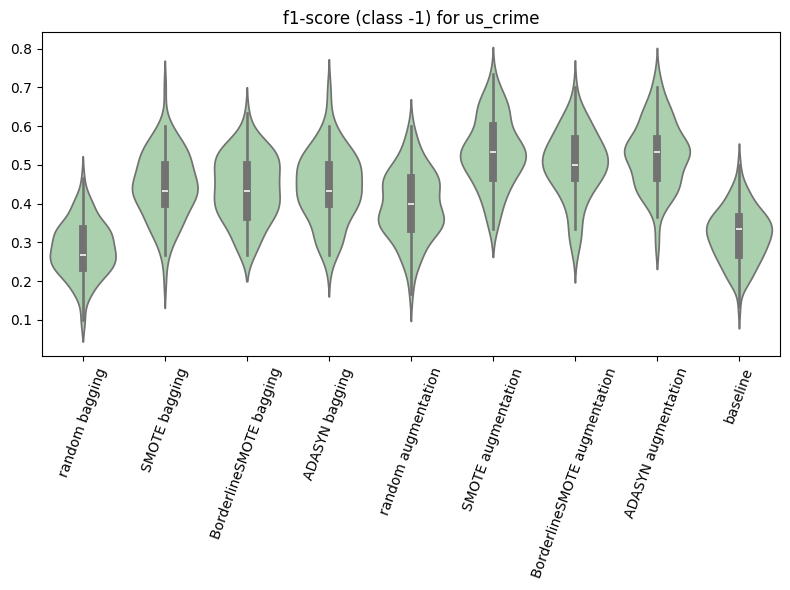

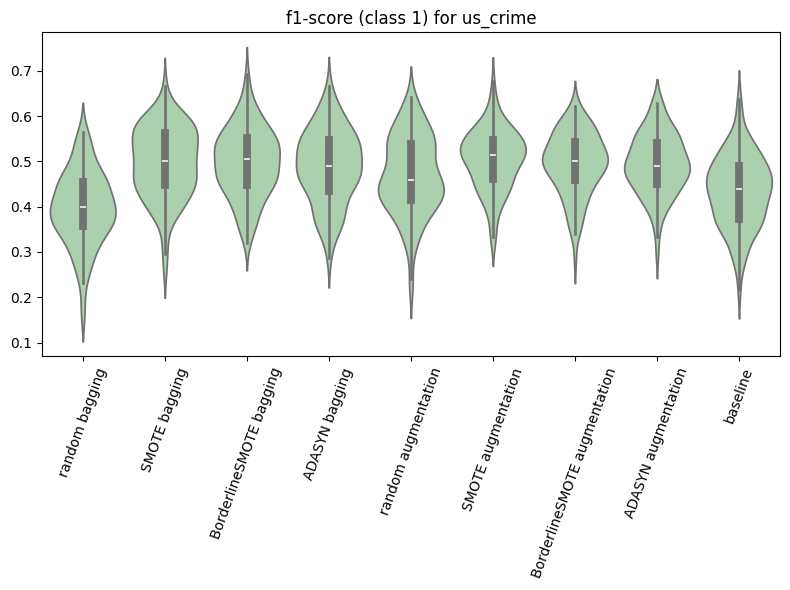

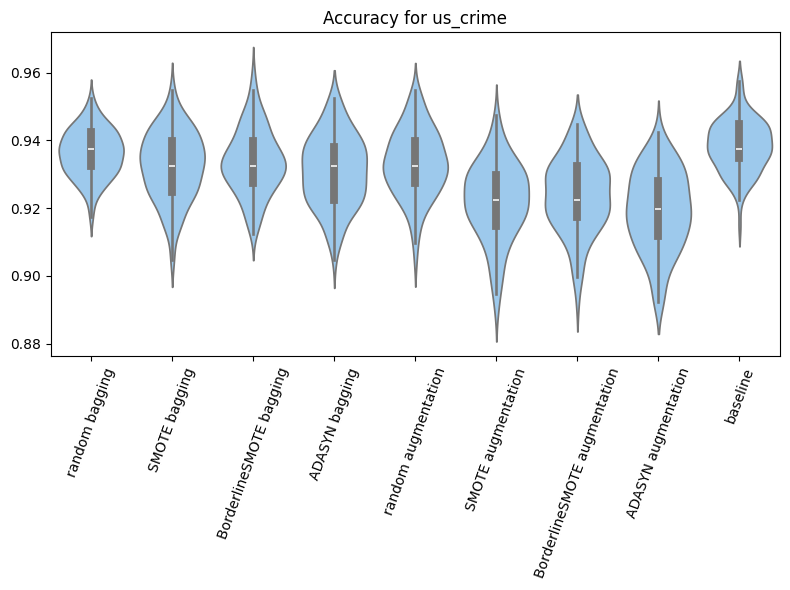

*****  DATASET: letter_img


 
 
+++ random - bagging


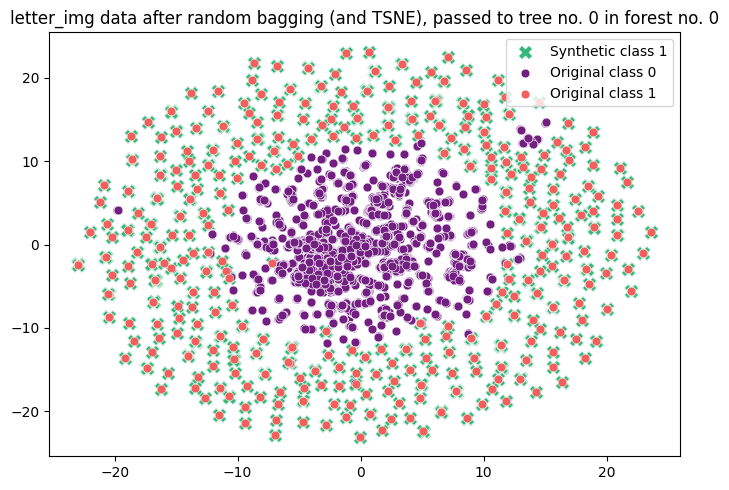


Class 0 has 15472 original samples and 0 synthetic samples after random oversampling.
Class 1 has 528 original samples and 14944 synthetic samples after random oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9946       0.9969       0.9990       0.0010
           1       0.9995       0.9999       1.0000       0.0002

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9972       0.9984       0.9995       0.0005
           1       0.9846       0.9960       1.0000       0.0052

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8571       0.9172       0.9728       0.0254
           1       0.9197       0.9548       0.9862       0.0141

    Accuracy          min          avg          max          std
                   0.9945       0.9968       0.9990       0.0009

 
 
+++ SMOTE - bagging


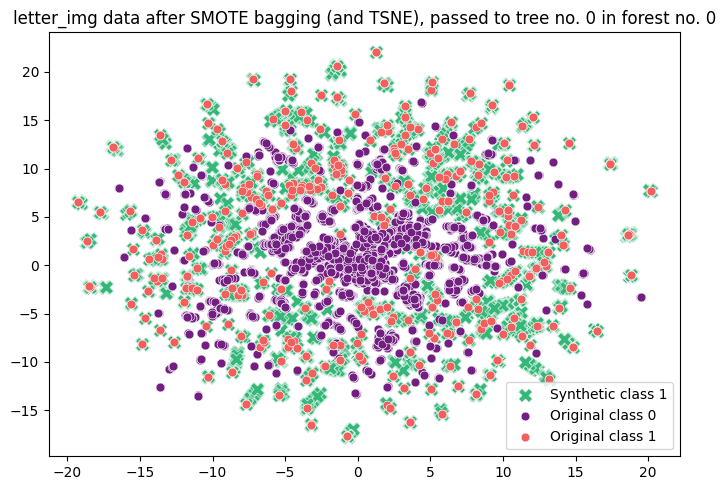


Class 0 has 15424 original samples and 0 synthetic samples after SMOTE oversampling.
Class 1 has 576 original samples and 14848 synthetic samples after SMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9951       0.9971       0.9987       0.0008
           1       0.9990       0.9998       1.0000       0.0002

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9974       0.9985       0.9992       0.0004
           1       0.9716       0.9951       1.0000       0.0055

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8707       0.9233       0.9660       0.0203
           1       0.9275       0.9577       0.9793       0.0109

    Accuracy          min          avg          max          std
                   0.9950       0.9970       0.9985       0.0007

 
 
+++ BorderlineSMOTE - bagging


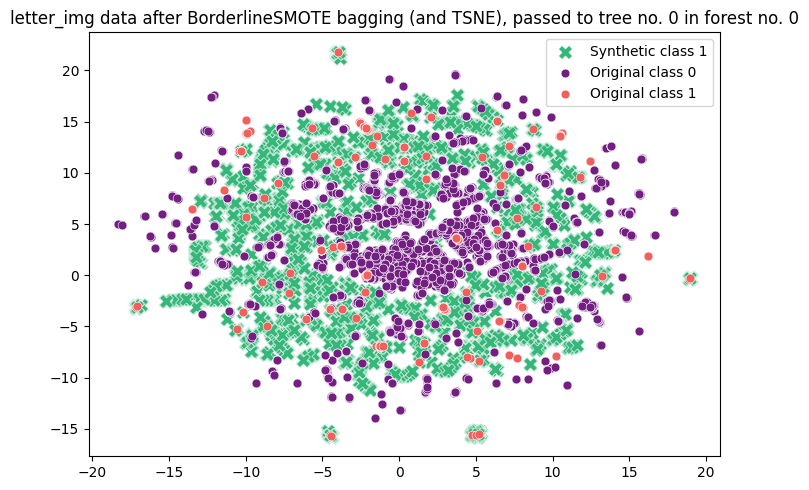


Class 0 has 15389 original samples and 0 synthetic samples after BorderlineSMOTE oversampling.
Class 1 has 611 original samples and 14778 synthetic samples after BorderlineSMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9948       0.9973       0.9987       0.0007
           1       0.9995       0.9999       1.0000       0.0001

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9974       0.9986       0.9994       0.0004
           1       0.9855       0.9982       1.0000       0.0039

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8639       0.9285       0.9660       0.0190
           1       0.9270       0.9620       0.9827       0.0102

    Accuracy          min          avg          max          std
                   0.9950       0.9973       0.9988       0.0007

 
 
+++ ADASYN - bagging


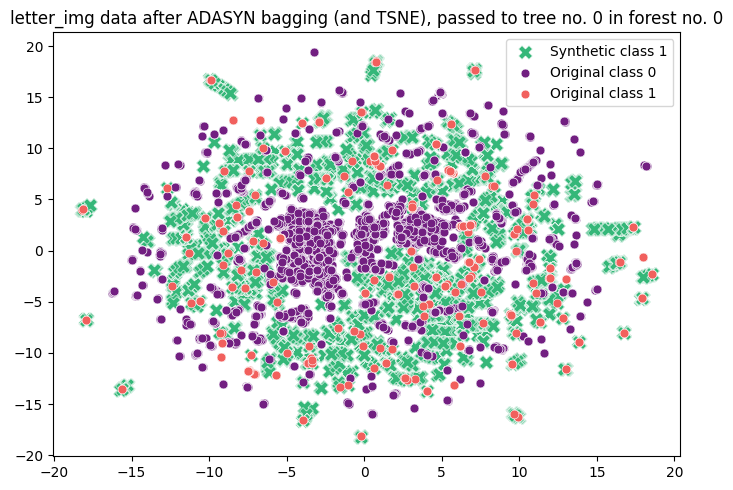


Class 0 has 15450 original samples and 0 synthetic samples after ADASYN oversampling.
Class 1 has 550 original samples and 14896 synthetic samples after ADASYN oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9953       0.9974       0.9990       0.0008
           1       0.9992       0.9998       1.0000       0.0002

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9975       0.9986       0.9995       0.0004
           1       0.9784       0.9956       1.0000       0.0056

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8776       0.9322       0.9728       0.0200
           1       0.9314       0.9628       0.9862       0.0113

    Accuracy          min          avg          max          std
                   0.9952       0.9974       0.9990       0.0008

 
+++ random - augmentation +++


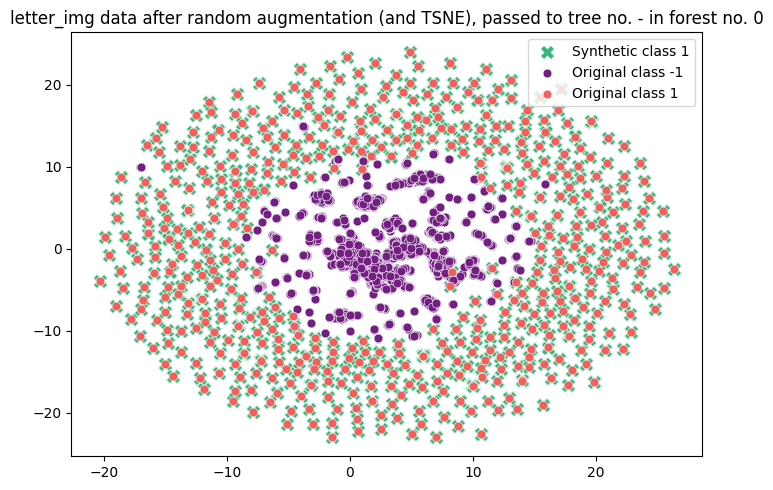


Class -1 has 15413 original samples and 0 synthetic samples after random oversampling.
Class 1 has 587 original samples and 14826 synthetic samples after random oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9959       0.9978       0.9995       0.0007
           1       0.9984       0.9996       1.0000       0.0003

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9975       0.9987       0.9996       0.0004
           1       0.9600       0.9904       1.0000       0.0092

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8912       0.9420       0.9864       0.0190
           1       0.9324       0.9654       0.9898       0.0109

    Accuracy          min          avg          max          std
                   0.9952       0.9975       0.9992       0.0008

 
+++ SMOTE - augmentation +++


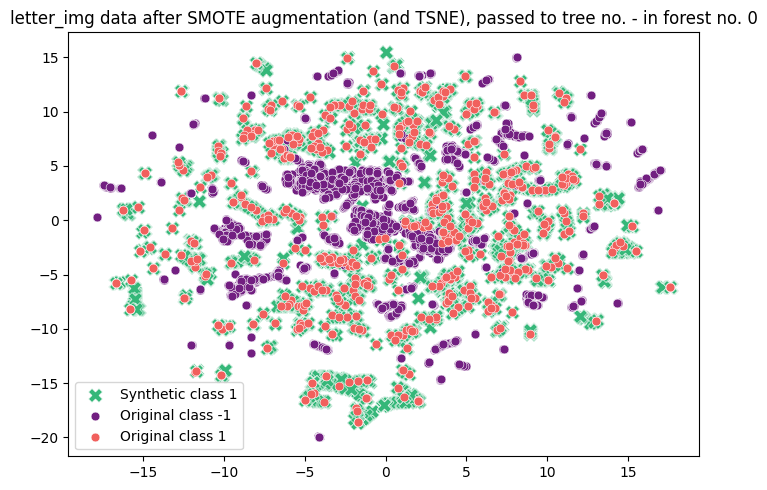


Class -1 has 15413 original samples and 0 synthetic samples after SMOTE oversampling.
Class 1 has 587 original samples and 14826 synthetic samples after SMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9951       0.9975       0.9997       0.0008
           1       0.9982       0.9997       1.0000       0.0003

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9974       0.9986       0.9997       0.0004
           1       0.9517       0.9916       1.0000       0.0088

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8707       0.9346       0.9932       0.0216
           1       0.9275       0.9621       0.9932       0.0123

    Accuracy          min          avg          max          std
                   0.9950       0.9973       0.9995       0.0009

 
+++ BorderlineSMOTE - augmentation +++


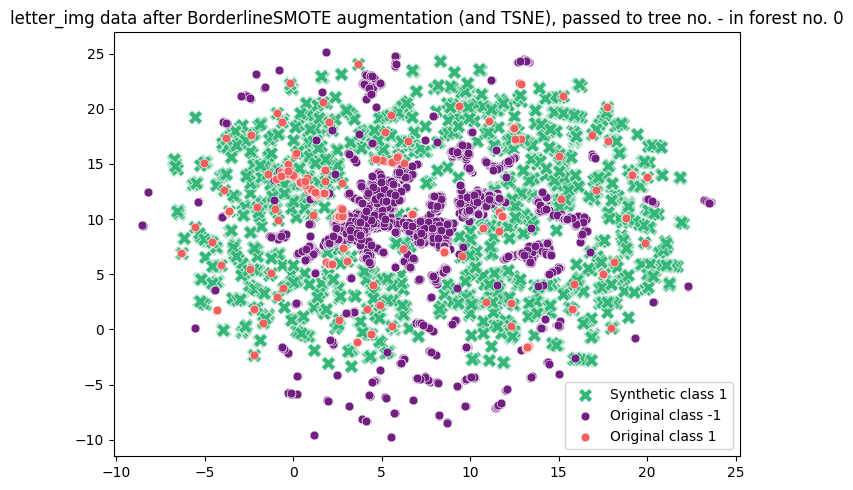


Class -1 has 15413 original samples and 0 synthetic samples after BorderlineSMOTE oversampling.
Class 1 has 587 original samples and 14826 synthetic samples after BorderlineSMOTE oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9954       0.9973       0.9987       0.0007
           1       0.9990       0.9998       1.0000       0.0002

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9977       0.9985       0.9992       0.0004
           1       0.9718       0.9939       1.0000       0.0069

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8776       0.9287       0.9660       0.0193
           1       0.9348       0.9601       0.9793       0.0111

    Accuracy          min          avg          max          std
                   0.9955       0.9972       0.9985       0.0008

 
+++ ADASYN - augmentation +++


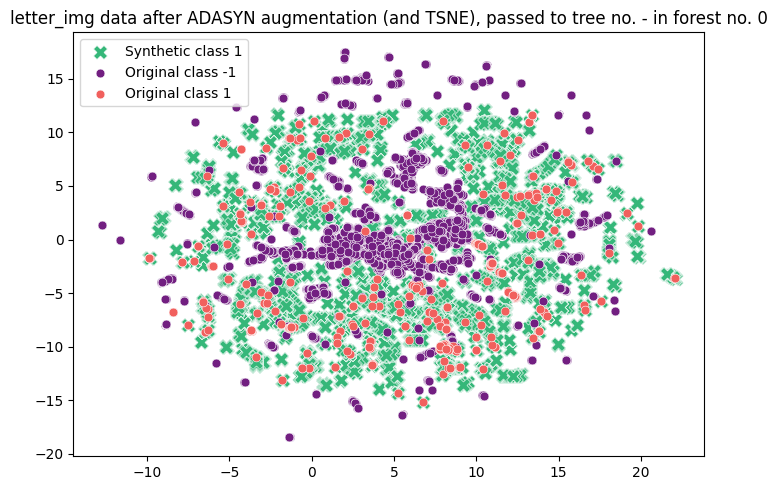


Class -1 has 15413 original samples and 0 synthetic samples after ADASYN oversampling.
Class 1 has 587 original samples and 14842 synthetic samples after ADASYN oversampling.


             min_precision avg_precision max_precision std_precision
          -1       0.9956       0.9975       0.9992       0.0008
           1       0.9987       0.9997       1.0000       0.0003

               min_recall   avg_recall   max_recall   std_recall
          -1       0.9975       0.9986       0.9996       0.0004
           1       0.9650       0.9915       1.0000       0.0083

             min_f1-score avg_f1-score max_f1-score std_f1-score
          -1       0.8844       0.9334       0.9796       0.0208
           1       0.9324       0.9614       0.9897       0.0115

    Accuracy          min          avg          max          std
                   0.9952       0.9973       0.9992       0.0008

             min_precision avg_precision max_precision std_precision
          -1       0.9953     

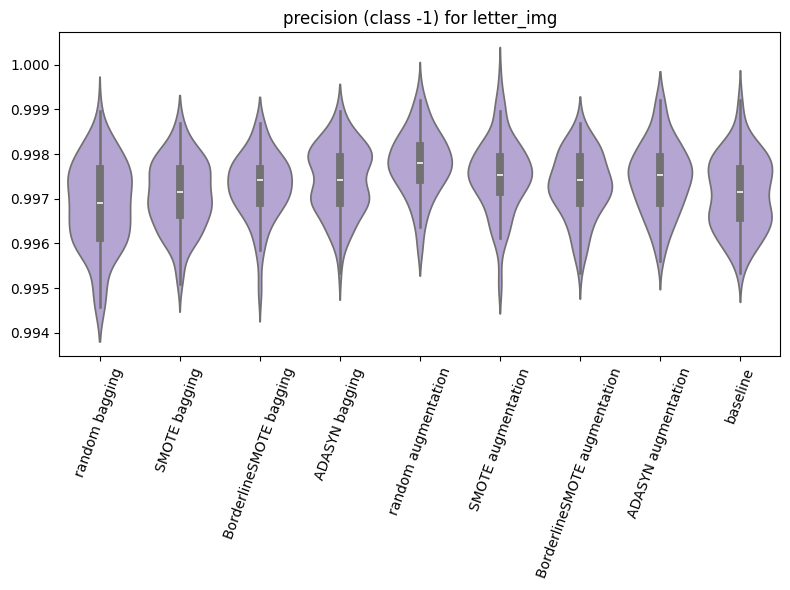

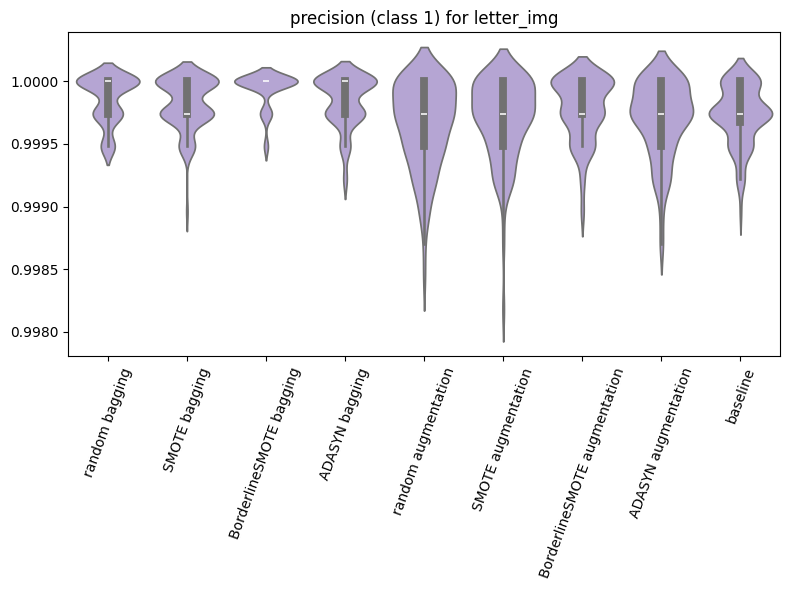

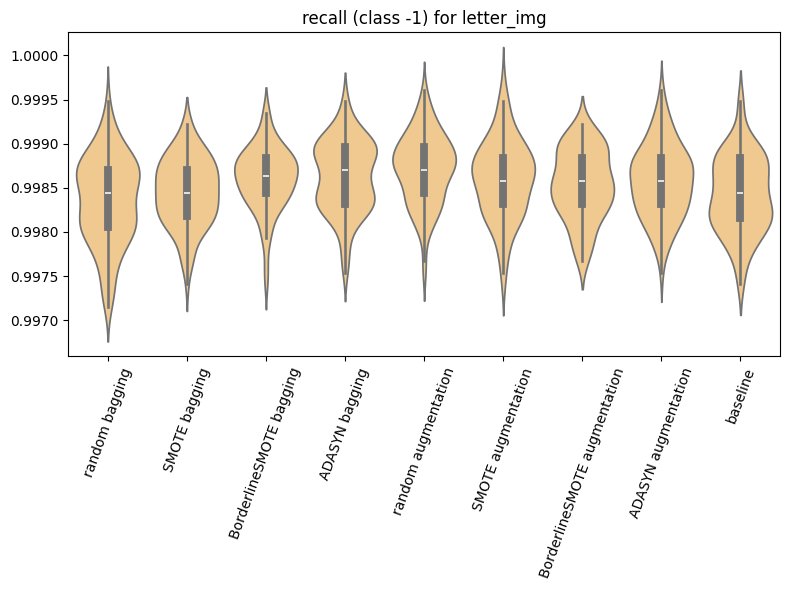

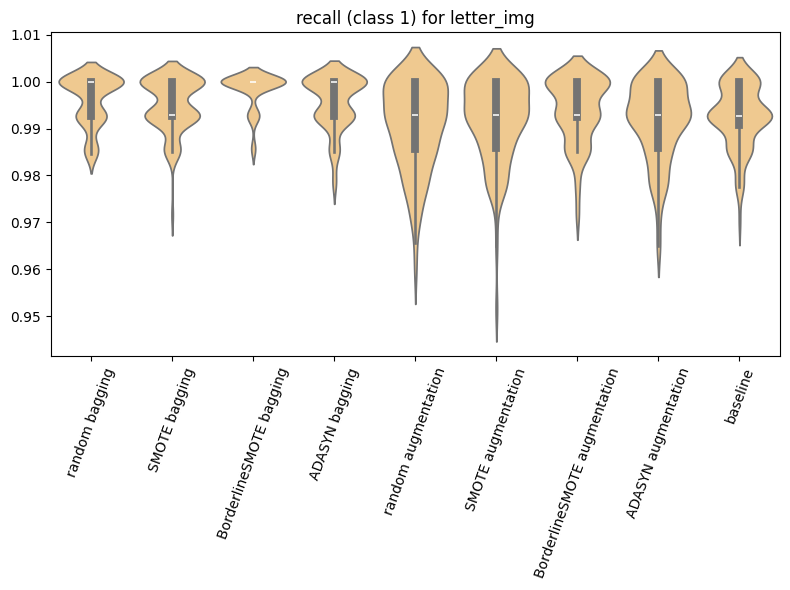

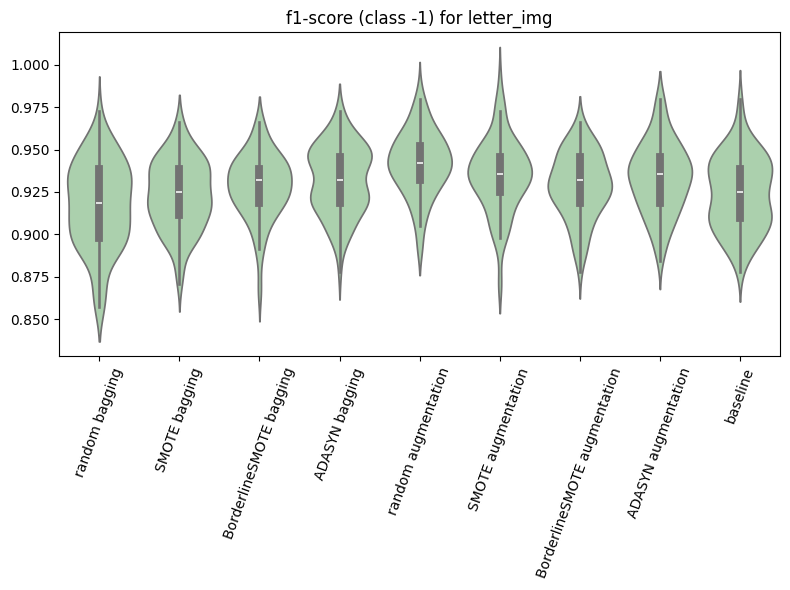

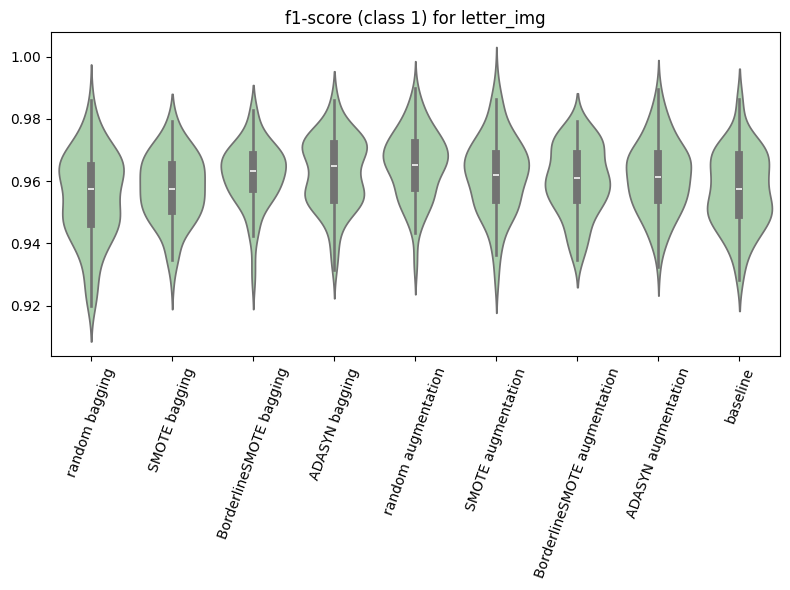

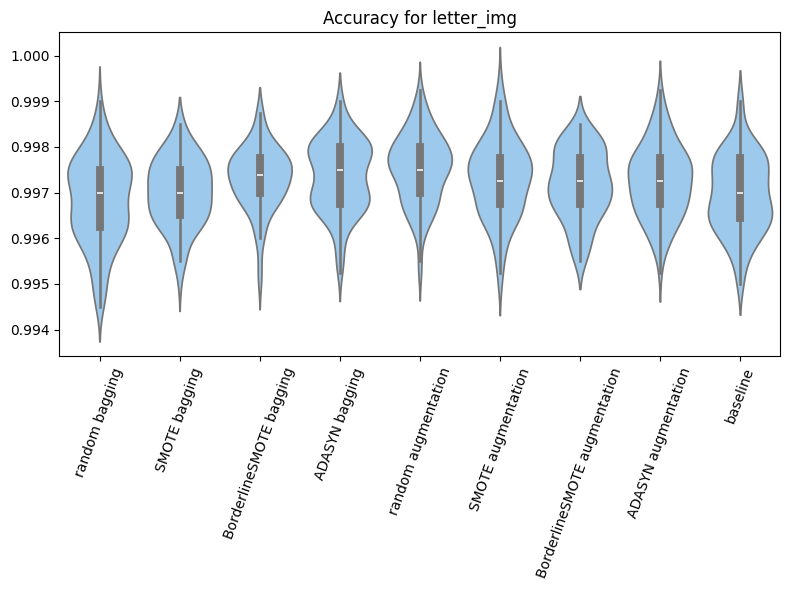

In [77]:
comparator.summary()